##**Contexto**
Uma empresa bem estabelecida operando no setor de alimentos e varejo que atende quase um milhão de consumidores por ano, por meio de 3 canais de venda: loja física, catálogos e site da empresa, notou que apesar de ter tido receitas sólidas nos últimos 3 anos as perspectivas de crescimento do lucro para os próximos anos não são promissoras. Por esse motivo, várias iniciativas estratégicas estão sendo consideradas para reverter essa situação. Uma delas é melhorar o desempenho das atividades de marketing, com foco especial em campanhas de marketing.

##**Problema de negócio**
As perspectivas de crescimento do lucro para os próximos anos não são promissoras, com o objetivo de mudar este cenário a equipe de marketing foi pressionada a gastar seu orçamento anual com mais sabedoria, o caminho escolhido foi construir um modelo que preveja o comportamento do cliente (comprador) de forma que eles consigam escolher a dedo os clientes mais propensos a comprar a oferta.  

###**Objetivos**
  - Com base em dados de uma campanha piloto, quais clientes têm maior propensão para adquirir um produto em uma nova campanha? 
  - Além disso, o CMO está interessado em entender e estudar as características dos clientes que estão dispostos a comprar o produto.


##Dados 
Os dados são sobre uma campanha piloto de uma empresa varejista onde 2.240 clientes  foram contatados. Os dados contêm recursos sociodemográficos,  além disso, ele contém um sinalizador para aqueles clientes que responderam à campanha, comprando o produto.

###Variaveis

**AcceptedCmp(1~5)** - se o cliente aceitou a oferta na (1 ~ 5) camapanha (1 sim / 0 não)

**Response(target)** - Se o cliente aceitou a oferta na ultima campanha (1 sim / 0 não)

**Complain** - Se o cliente reclamou nos ultimos 2 anos 

**DtCustomer** - Data de inscrição do cliente na empresa

**Education** - Nivel de educação do cliente 

**Maritial** - Estado civil do cliente 

**KidHome** - numero de crianças na casa do cliente 

**TeenHome** - numero de adolescentes na casa do cliente 

**Income** - Renda familiar do Cliente 

**MntFishProducts** - Quantia gasta em produtos de peixe nos ultimos 2 anos 

**MntmeatProducts** - Quantia gasta em produtos de carne nos ultimos 2 anos 

**MntFruitsProducts** - Quantia gasta em produtos de frutas nos ultimos 2 anos 

**MntsweetProducts** - Quantia gasta em produtos de doces nos ultimos 2 anos 

**MntWineProducts** - Quantia gasta em produtos de vinhos nos ultimos 2 anos 

**MntGoldProducts** - Quantia gasta em produtos de Ouro nos ultimos 2 anos 

**NumDealsPurchases** - numero de compras feitas com desconto 

**NumCatalogPurchases** - numero de compras feitas usando o catalogo 

**NumStorePurchases** - numero de compras feitas diretamente na loja

**NumWebPurchases** = Numero de compras feitas pelo web site. 

**NumWebVisitsMonth** - Numero de visitas feitas no site no ultimo mes 

**Recency** - Numero de dias desde a ultima compra 



## Importando Bibliotecas

In [353]:
#importando bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Modelagem
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#testes de hipotese 
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
import itertools

#clustering 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

from sklearn.preprocessing import PowerTransformer

#aumentando o limite de colunas a ser exbida
pd.set_option("display.max_columns", 400) 

import warnings
warnings.simplefilter(action='ignore')



In [354]:
#importando o Dataset
df = pd.read_csv('/content/ml_project1_data.csv')


In [355]:
#divindo em treino e teste 

X = df.drop('Response', axis = 1)
y = df.Response

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30, random_state=2806,stratify=y)

#concatenando o conjunto de treino para df_train 
df_train = pd.concat([X_train,y_train], axis = 1)



##FUNÇÕES

In [356]:
#Função para calcular a curva FAR e FRR
def calculate_far_frr(y_proba, y_true, n_points=60, normalize=False, threshold=None):
    thr = np.linspace(0, 1, n_points)
    far = []
    frr = []
    for t in thr:
        far_pt = y_proba[y_true == 0] >= t
        frr_pt = y_proba[y_true == 1] < t
        if normalize:
            far.append(far_pt.mean())
            frr.append(frr_pt.mean())
        else:
            far.append(far_pt.sum())
            frr.append(frr_pt.sum())
    
    far = np.array(far)
    frr = np.array(frr)
    
    if threshold is None:
        optm = thr[abs(far - frr).argmin()]
    else:
        optm = threshold
    
    return {'optm': optm, 'plot': pd.DataFrame(index=thr, data={'far': far, 'frr': frr}, dtype=float)}

In [357]:
#função para calcular a distancia de mahalanobis 
def mahalanobis_distance(data_numeric):

    #Calculando a matrix de covariancia.
    cov = np.cov(data_numeric, rowvar=False)
    
    #Verificando se a matrix de covariancia e positiva 
    if not np.allclose(cov, cov.T) or np.isnan(cov).any():
        raise ValueError('A matriz de covariância não é positiva definida ou contém NaNs')
    
    #Calculando a matriz de covariância inversa
    inv_cov = np.linalg.inv(cov)
    
    #Calculando a media de cada variavel 
    vars_mean = data_numeric.mean(axis=0).values
    
    # Calculando a distancia Mahalanobis para cada linha de data_numeric
    diff = data_numeric - vars_mean
    md = np.sqrt(np.einsum('ij,ij->i', diff.dot(inv_cov), diff))
    
    #Calculando a media e o desvio padrão da distancia de Mahalanobis
    md_mean = md.mean()
    md_std = md.std()
    
    return md, md_mean, md_std

#função para remover outliers do conjunto de treinamento 
def remove_outliers(data, threshold=3):
    #Filtrando apenas as colunas numericas 
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    data_numeric = data[numeric_cols]
    
    # Calculando a distancia de Mahalanobis do conjunto de treino 
    md, md_mean, md_std = mahalanobis_distance(data_numeric)
    
    #Calcula o threshold para remoção dos outliers 
    threshold = md_mean + threshold * md_std
    
    #Identificando os outliers 
    outliers = data[md > threshold]
    
    #Remove os outliers 
    data = data[md <= threshold].values
    
    return data


In [358]:
from scipy import stats

# Função de Potenciação de features 
def transformacao_potencia(df, target):

    # Dicionário com as funções de transformação
    dicionario_transf = {
        "x": lambda x: x,
        "raiz_quadrada": np.sqrt,
        "exponencial": np.exp,
        "**1/4": lambda x: np.power(x, 0.25),
        "**2": lambda x: np.power(x, 2),
        "**4": lambda x: np.power(x, 4),
        "cubo": lambda x: np.power(x, 3),
        "seno": np.sin,
        "cosseno": np.cos
    }

    # Dicionário com as melhores transformações para cada variável
    dicionario_melhor_transf = {}

    for coluna in df.columns[:-1]:
        max_valor_teste, melhor_transf, melhor_transf_potencia = 0, "", None

        # Testa todas as transformações para a coluna e escolhe a melhor
        for chave, valor in dicionario_transf.items():
            coluna_transf = valor(df[coluna])

            # Tratamento de valores infinitos e negativos no logaritmo
            #if chave == "log":
            #    coluna_transf = coluna_transf.replace([-np.inf, np.inf], -50.)

            # Contagem dos valores de cada classe do target para cada faixa de valores transformados da coluna
            coluna_transf.replace([-np.inf, np.inf], -50., inplace=True)
            cont_tab = pd.crosstab(pd.cut(coluna_transf, bins=10), df[target])
            coluna_transf.fillna(-np.inf, inplace=True)
            # Teste de chi-quadrado para avaliar a independência entre a coluna transformada e o target
            valor_teste_chi = stats.chi2_contingency(cont_tab)[0]

            # Atualização da melhor transformação para a coluna
            if valor_teste_chi > max_valor_teste:
                max_valor_teste, melhor_transf, melhor_transf_potencia = valor_teste_chi, chave, coluna_transf

        dicionario_melhor_transf[coluna] = (max_valor_teste, melhor_transf, melhor_transf_potencia)
        df[coluna] = melhor_transf_potencia

    return df, dicionario_melhor_transf


In [359]:
#função para remover outliers do conjunto de teste com base no threshold do conjunto de treinamento. 
def remove_outliers_test(train_data, test_data, threshold=3):

    #Filtrando apenas colunas numericas do conjunto de treino 
    numeric_cols = train_data.select_dtypes(include=[np.number]).columns
    train_numeric = train_data[numeric_cols]
    
    # calculando a distancia de Mahalanobis para train_numeric 
    md_train, md_train_mean, md_train_std = mahalanobis_distance(train_numeric)
    
    #Calculando o limite para outliers(threshold) no conjunto de teste com base nas estatísticas do conjunto de treino 
    threshold_test = md_train_mean + threshold * md_train_std
    
    #Filtrando apenas as colunas numericas no conjunto de teste 
    test_numeric = test_data[numeric_cols]
    
    #Calculando a distância de Mahalanobis para test_numeric
    md_test, _, _ = mahalanobis_distance(test_numeric)
    
    #Identificando outliers no conjunto de teste com base nas estatisticas do conjunto de treinamento 
    outliers = test_data[md_test > threshold_test]
    
    # Removendo Outliers do conjunto de teste 
    test_data = test_data[md_test <= threshold_test].values
    
    return test_data


In [360]:
from scipy import stats

#Função de Potenciação de features conjunto Teste
def transformacao_potencia_test(X_train, X_test, y_train):
  
  #Dicionário com as funções de transformação
  dicionario_transf = {
        "x": lambda x: x,
        "raiz_quadrada": np.sqrt,
        "exponencial": np.exp,
        "**1/4": lambda x: np.power(x, 0.25),
        "**2": lambda x: np.power(x, 2),
        "**4": lambda x: np.power(x, 4),
        "cubo": lambda x: np.power(x, 3),
        "seno": np.sin,
        "cosseno": np.cos
  }

  #Dicionário com as melhores transformações para cada variável
  dicionario_melhor_transf = {}
  for coluna in X_train.columns:
      max_valor_teste, melhor_transf, melhor_transf_potencia = 0, "", None
      
      #Testa todas as transformações para a coluna e escolhe a melhor
      for chave, valor in dicionario_transf.items():
          coluna_transf = valor(X_train[coluna])
          
          #Tratamento de valores infinitos e negativos no logaritmo
          if chave == "log":
              coluna_transf = coluna_transf.replace([-np.inf, np.inf], -50.)

          #Contagem dos valores de cada classe do target para cada faixa de valores transformados da coluna
          coluna_transf.replace([-np.inf, np.inf], -50., inplace=True)
          cont_tab = pd.crosstab(pd.cut(coluna_transf, bins=10), y_train)
          
          #Teste de chi-quadrado para avaliar a independência entre a coluna transformada e o target
          valor_teste_chi = stats.chi2_contingency(cont_tab)[0]

          #Atualização da melhor transformação para a coluna
          if valor_teste_chi > max_valor_teste:
              max_valor_teste, melhor_transf, melhor_transf_potencia = valor_teste_chi, chave, coluna_transf      

      dicionario_melhor_transf[coluna] = (max_valor_teste, melhor_transf, melhor_transf_potencia)
      X_train[coluna] = melhor_transf_potencia
      #aplica a melhor transformação obtida pelo conjunto de treinamento no conjunto de teste
      if melhor_transf != "":
        X_test[coluna] = dicionario_transf[melhor_transf](X_test[coluna])

  return X_test, dicionario_melhor_transf


## Analise Exploratoria

In [361]:
#visualizando o dataset
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [362]:
#verificando o tipo de cada coluna 
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1568 entries, 1391 to 1431
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   1568 non-null   int64  
 1   Year_Birth           1568 non-null   int64  
 2   Education            1568 non-null   object 
 3   Marital_Status       1568 non-null   object 
 4   Income               1553 non-null   float64
 5   Kidhome              1568 non-null   int64  
 6   Teenhome             1568 non-null   int64  
 7   Dt_Customer          1568 non-null   object 
 8   Recency              1568 non-null   int64  
 9   MntWines             1568 non-null   int64  
 10  MntFruits            1568 non-null   int64  
 11  MntMeatProducts      1568 non-null   int64  
 12  MntFishProducts      1568 non-null   int64  
 13  MntSweetProducts     1568 non-null   int64  
 14  MntGoldProds         1568 non-null   int64  
 15  NumDealsPurchases    1568 non-null 

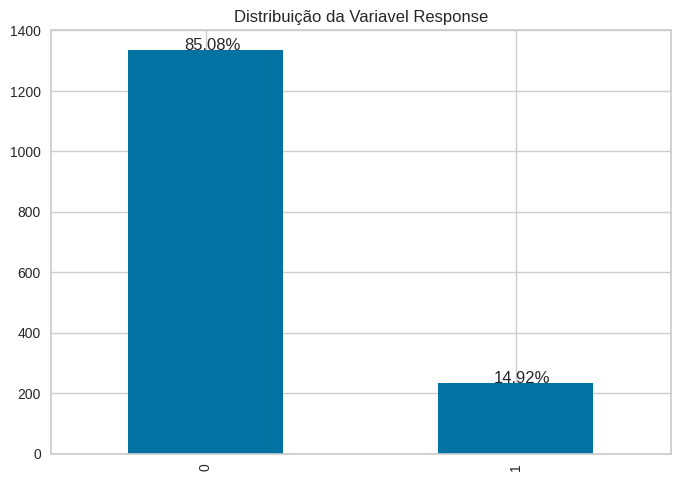

In [363]:
#visualizando a distribuição da variavel target 
ax = df_train.Response.value_counts().plot(kind='bar')
plt.title('Distribuição da Variavel Response')
for p in ax.patches: # patches pega as colunas 
  #multiplicando o tamanho da coluna por 100 e dividindo pelo tamanho da variavel target
  ax.annotate('{:.2f}%'.format(100*p.get_height()/len(df_train.Response)), (p.get_x()+ 0.18, p.get_height()))

É possivel perceber que a variavel Target segue a distribuiçao descrita no contexto do problema apenas 15% dos clientes compraram o produto 

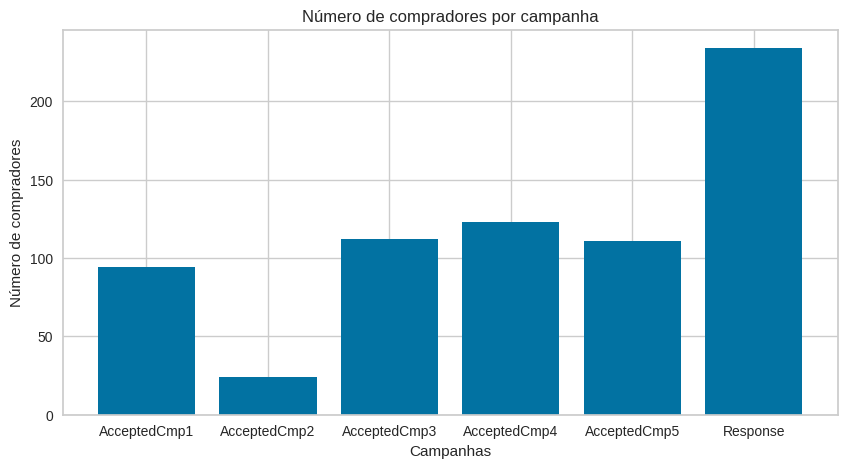

In [364]:
# selecionando as colunas de campanha.
df_cmp = df_train[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5','Response']]
# calculando o número de compradores para cada campanha (somando os 1)
compraram = df_cmp.sum()

#plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(compraram.index, compraram)
ax.set_xlabel("Campanhas")
ax.set_ylabel("Número de compradores")
ax.set_title("Número de compradores por campanha")
plt.show()


A segunda camapanha teve desempenho muito inferior as demais camapanhas, presupondo que TODOS os 2240 clientes receberam a mesma oferta em todas as campanhas, não deve ser possivel diferenciar por perfil de cliente(uma vez que todos foram contatados), talvez possa ser algo de sazonalidade já que as campanhas foram ofertadas em meses diferentes. 

In [365]:
# Criando uma nova coluna chamada 'TotalComprou' baseada nas campanhas anteriores 
df_train['TotalComprou'] = df_train[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].sum(axis=1)


- Para uma melhor visualização do relacionamento das campanhas anteriores com outras features estou criando a feature TotalComprou que representa a soma de compras das campanhas anteriores

Text(0.5, 1.0, 'Distribuição da variavel Renda')

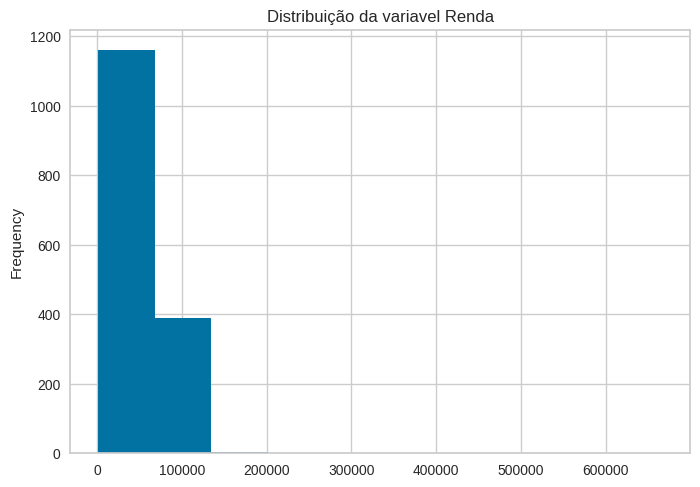

In [366]:
#verificando a distribuição da feature Income
df_train.Income.plot(kind = 'hist')
plt.title('Distribuição da variavel Renda')

Durante a analise exploratoria identifiquei que a feature Income estava com outliers muito descrepantes. optei por fazer a tratativa aqui no começo de forma que facilitasse a visualização dos plots com esta feature.

In [367]:
#visualizando os percentis da variavel Income 
df_train.Income.describe(percentiles = [0.10, 0.25,0.5,0.75,0.99])

count      1553.000000
mean      52229.091436
std       26401.727232
min        1730.000000
10%       24090.200000
25%       35340.000000
50%       51267.000000
75%       68627.000000
99%       93874.400000
max      666666.000000
Name: Income, dtype: float64

Estou visualizando os percentis, coloquei o 99% para confirmar os outliers e saber o valor que irei trunkar. 

In [368]:
#Trunkando a Variavel Income em percentil 99%
p99 = df_train['Income'].quantile(0.99)
df_train['Income'] = np.where(df_train['Income'] > p99, p99, df_train['Income'])

- Eu trunkei a Feature Income em 99% para remover os outliers porem posso voltar aqui e optar por outra abordagem como remover esses valores 

Text(0.5, 1.0, 'Distribuição da renda por nível de educação dos clientes com relação à campanhas anteriores')

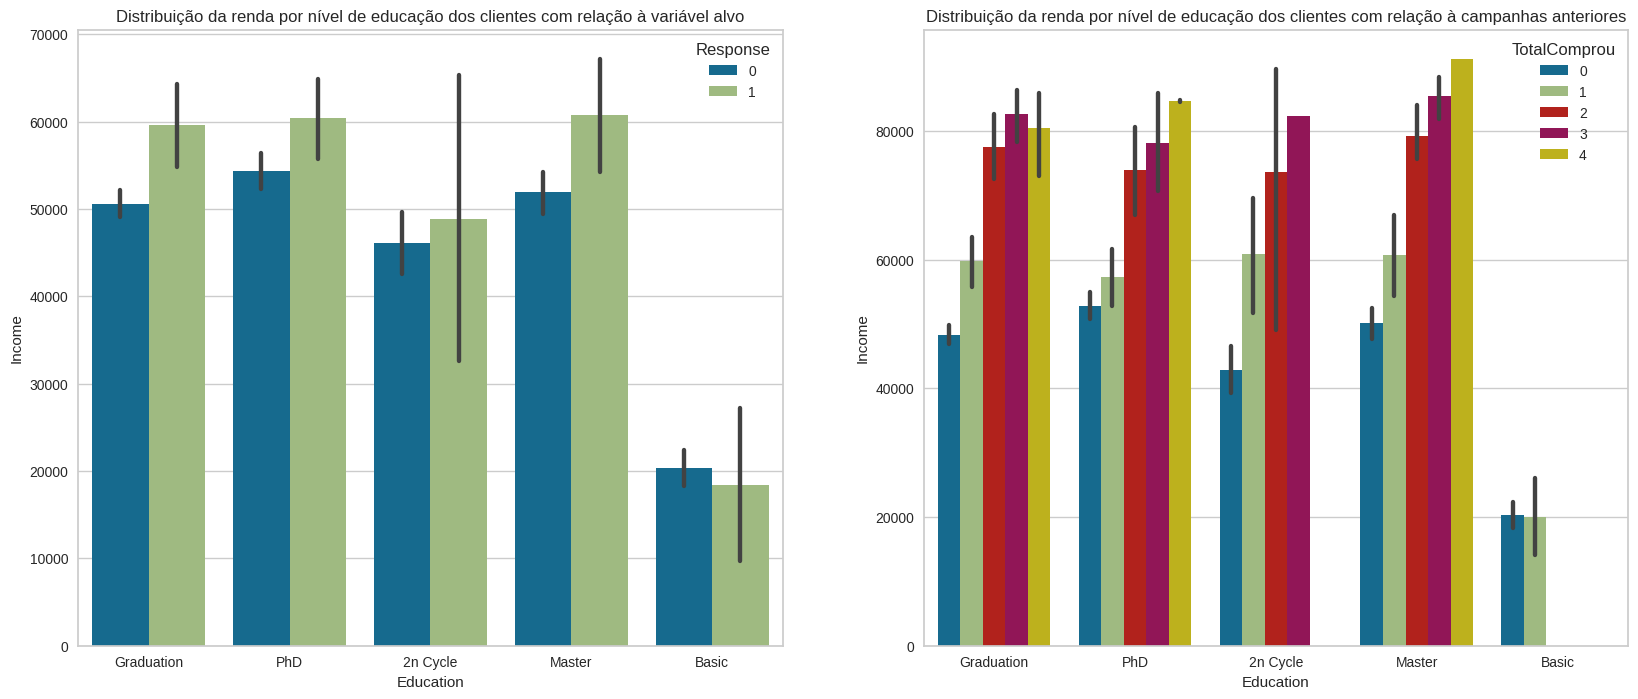

In [369]:
#verificando se o nivel de escolaridade influencia na obtenção do produto. 
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.barplot(data=df_train, x='Education', y='Income', hue='Response')
plt.title('Distribuição da renda por nível de educação dos clientes com relação à variável alvo')

plt.subplot(1,2,2)
sns.barplot(data=df_train, x='Education', y='Income', hue='TotalComprou')
plt.title('Distribuição da renda por nível de educação dos clientes com relação à campanhas anteriores')

Os clientes que adquiriram o produto apresentam um nível de escolaridade maior em comparação aos clientes que não adquiriram. 

In [370]:
'''#visualizando a compra do produto na campanha de marketing (target)
Mnt = pd.DataFrame(df_train, columns=['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds','Response'])
sns.pairplot(Mnt, hue='Response',markers=["o", "s"],height=1.7, aspect=1.5)'''

'#visualizando a compra do produto na campanha de marketing (target)\nMnt = pd.DataFrame(df_train, columns=[\'MntWines\',\'MntFruits\',\'MntMeatProducts\',\'MntFishProducts\',\'MntSweetProducts\',\'MntGoldProds\',\'Response\'])\nsns.pairplot(Mnt, hue=\'Response\',markers=["o", "s"],height=1.7, aspect=1.5)'

Não existe uma correlação muito espressiva entre os produtos oferecidos, é possivel perceber que existe alguns outliers e que a grande maioria das pessoas que adquiriram o novo produto pela ultima campanha de marketing(target), ja fizeram muitas compras de algum outro produto.

In [371]:
'''#visualizando as compras do produto em campanhas de marketing anteriores. 
Mnt = pd.DataFrame(df_train, columns=['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds','TotalComprou'])
sns.pairplot(Mnt, hue='TotalComprou',height=1.7, aspect=1.5)'''

"#visualizando as compras do produto em campanhas de marketing anteriores. \nMnt = pd.DataFrame(df_train, columns=['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds','TotalComprou'])\nsns.pairplot(Mnt, hue='TotalComprou',height=1.7, aspect=1.5)"

Fica mais nitido visualizar que os clientes que adquiriram o produto da campanha de marketing são clientes que ja compram algum produto com frequencia. 

Text(0, 0.5, 'N de Clientes que adquiriu o produto')

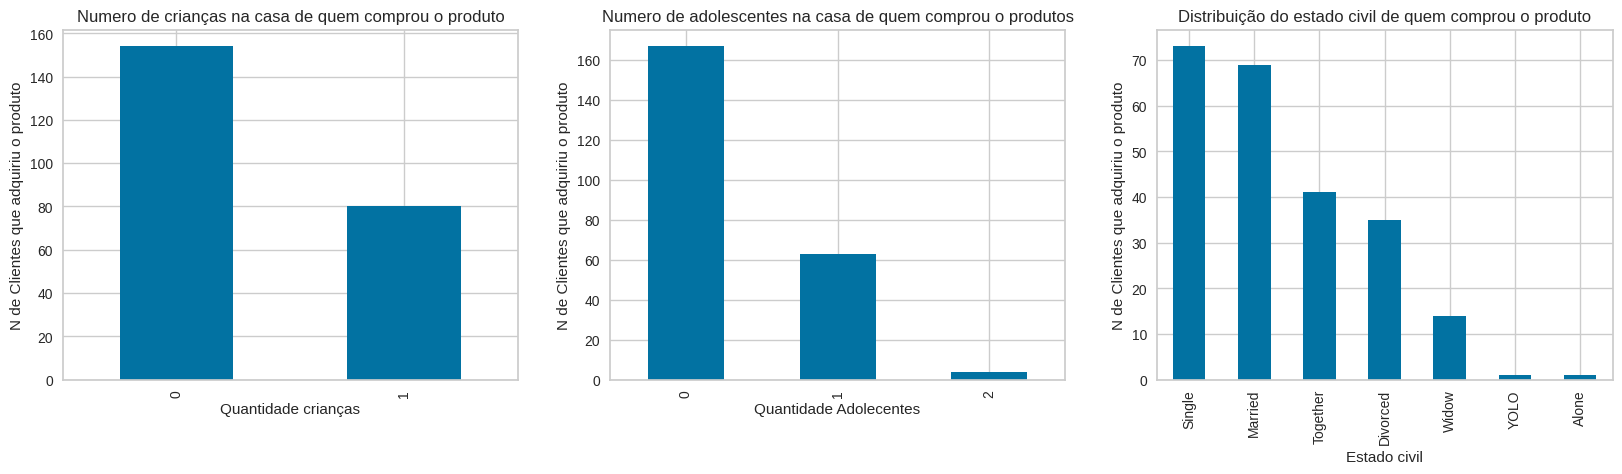

In [372]:
#plotando se existe diferença na quantidade de produtos adquiridos por pessoas que possuem filhos e por estado civil
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
df_train[df_train.Response == 1]['Kidhome'].value_counts().plot(kind='bar')
plt.title('Numero de crianças na casa de quem comprou o produto')
plt.xlabel('Quantidade crianças')
plt.ylabel('N de Clientes que adquiriu o produto')

plt.subplot(2,3,2)
df_train[df_train.Response == 1]['Teenhome'].value_counts().plot(kind='bar')
plt.title('Numero de adolescentes na casa de quem comprou o produtos')
plt.xlabel('Quantidade Adolecentes')
plt.ylabel('N de Clientes que adquiriu o produto')

plt.subplot(2,3,3)
df_train[df_train.Response == 1]['Marital_Status'].value_counts().plot(kind='bar')
plt.title('Distribuição do estado civil de quem comprou o produto')
plt.xlabel('Estado civil')
plt.ylabel('N de Clientes que adquiriu o produto')


- É possivel perceber que possuir filhos sejam eles crinças ou adolescente pode influenciar na aquisição do produto, ja o estado civil não parece ter alguma influencia mas tem algumas informações que não fazem muito sentido 

Text(0.5, 1.0, 'Diferença de renda de quem comprou ou não o produto')

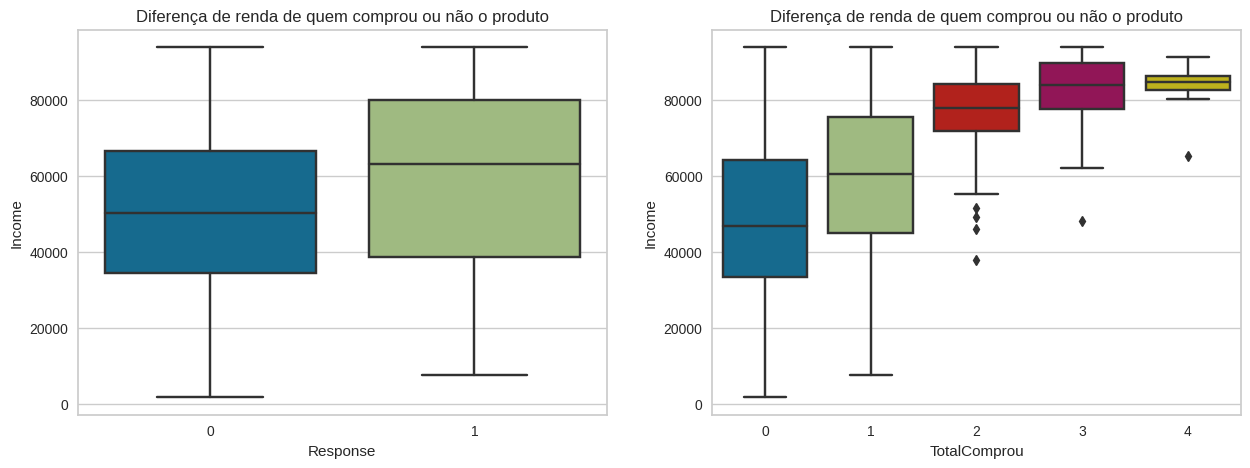

In [373]:
#verificando se existe diferença em quem adquiriu o produto e quem não adquiriu pelo valor da renda. 
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.boxplot(x="Response", y="Income", data=df_train)
plt.title('Diferença de renda de quem comprou ou não o produto')

plt.subplot(1,2,2)
sns.boxplot(x="TotalComprou", y="Income", data=df_train)
plt.title('Diferença de renda de quem comprou ou não o produto')

E possivel perceber que ter uma renda maior influencia se o cliente ira adquirir o produto. 

Text(0.5, 1.0, 'Quantidade de Gold Products comprados x Renda')

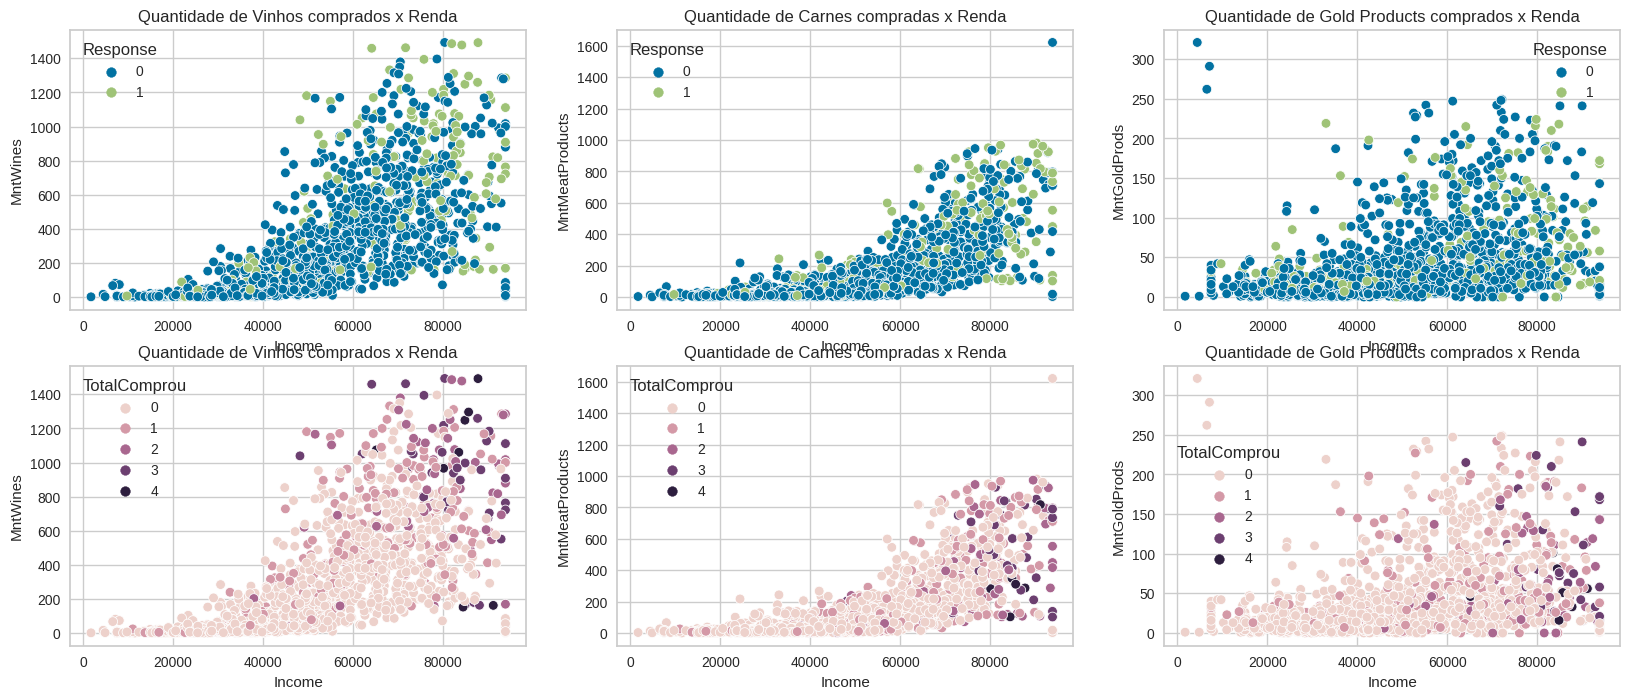

In [374]:
#verificando a relação de alguns produtos com a renda e onde estão os clientes que adquiriram o produto da campanha de marketing
plt.figure(figsize=(20,8))

plt.subplot(2,3,1)
sns.scatterplot(x='Income', y='MntWines', hue='Response', data=df_train)
plt.title('Quantidade de Vinhos comprados x Renda')
plt.subplot(2,3,2)
sns.scatterplot(x='Income', y='MntMeatProducts', hue='Response', data=df_train)
plt.title('Quantidade de Carnes compradas x Renda')
plt.subplot(2,3,3)
sns.scatterplot(x='Income', y='MntGoldProds', hue='Response', data=df_train)
plt.title('Quantidade de Gold Products comprados x Renda')

#Vizualizando pela feature Totalcomprou
plt.subplot(2,3,4)
sns.scatterplot(x='Income', y='MntWines', hue='TotalComprou', data=df_train)
plt.title('Quantidade de Vinhos comprados x Renda')
plt.subplot(2,3,5)
sns.scatterplot(x='Income', y='MntMeatProducts', hue='TotalComprou', data=df_train)
plt.title('Quantidade de Carnes compradas x Renda')
plt.subplot(2,3,6)
sns.scatterplot(x='Income', y='MntGoldProds', hue='TotalComprou', data=df_train)
plt.title('Quantidade de Gold Products comprados x Renda')

Os clientes que possuem mais renda adquirem mais produtos, e respondem mais as campanhas de marketing. 

Text(0, 0.5, 'Numero de visitas no site')

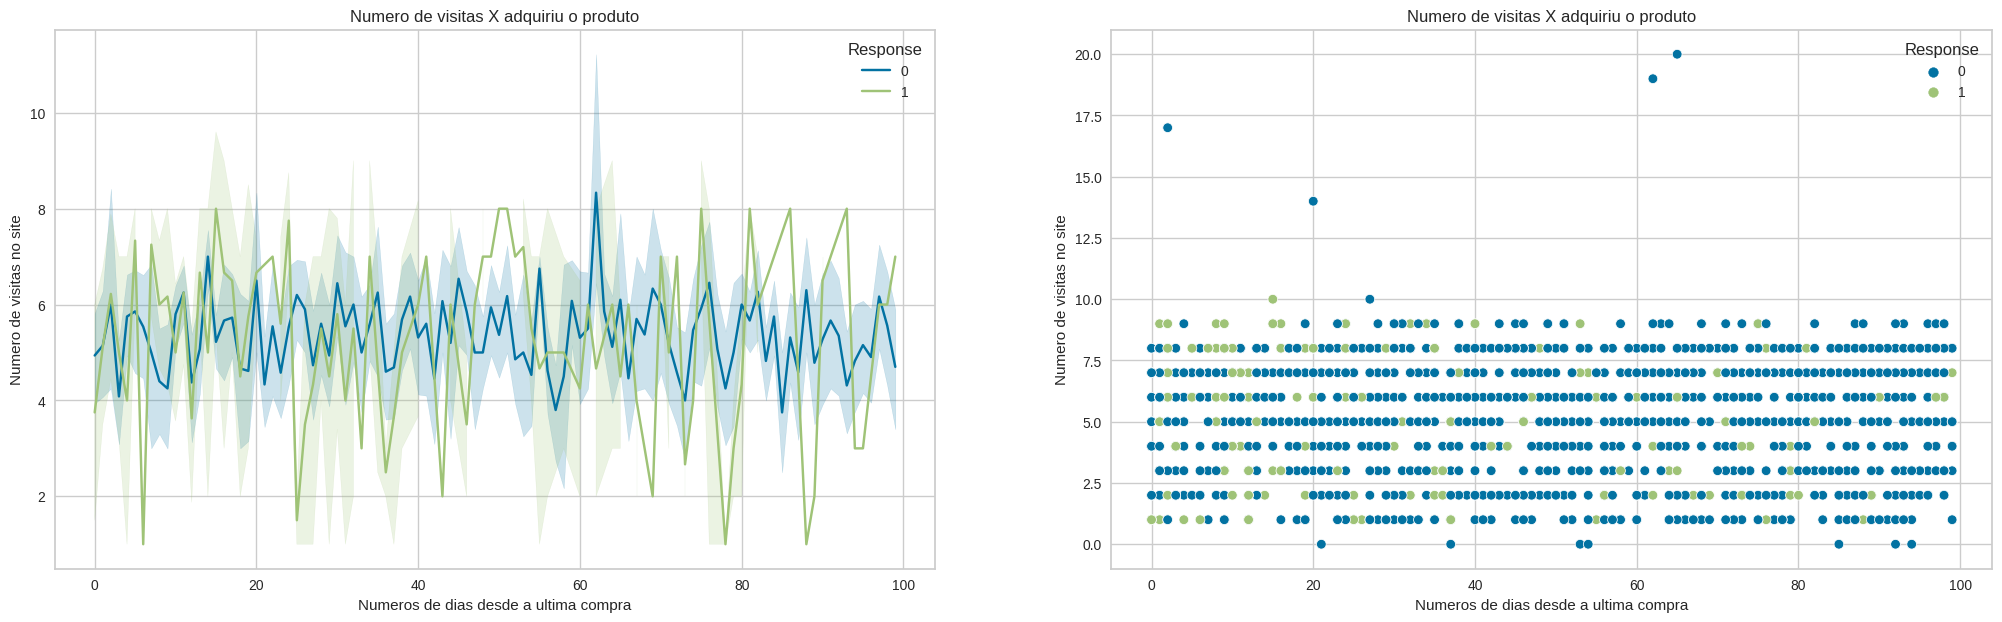

In [375]:
#vendo o numero de visitas no site desde a ultima compra e comparando com quem adquiriu o produto

# Criando um dataframe com as features NumWebVisitsMonth, Recency e Response
df_lineplot = df_train[['NumWebVisitsMonth', 'Recency', 'Response']]

# Plotando o line plot
plt.figure(figsize=(25,7))
plt.subplot(1,2,1)
sns.lineplot(data=df_train, x='Recency', y='NumWebVisitsMonth', hue='Response')
plt.title('Numero de visitas X adquiriu o produto')
plt.xlabel('Numeros de dias desde a ultima compra')
plt.ylabel('Numero de visitas no site')


plt.subplot(1,2,2)
sns.scatterplot(data=df_train, x='Recency', y='NumWebVisitsMonth', hue='Response')
plt.title('Numero de visitas X adquiriu o produto')
plt.xlabel('Numeros de dias desde a ultima compra')
plt.ylabel('Numero de visitas no site')


- aparentemente os clientes que adquiriram o produto da campanha de marketing visitaram o site mais rescentemente nos ultimos 40 dias. 

Text(0.5, 1.0, 'Numero de Compras com Desconto X Adquiriu o produto')

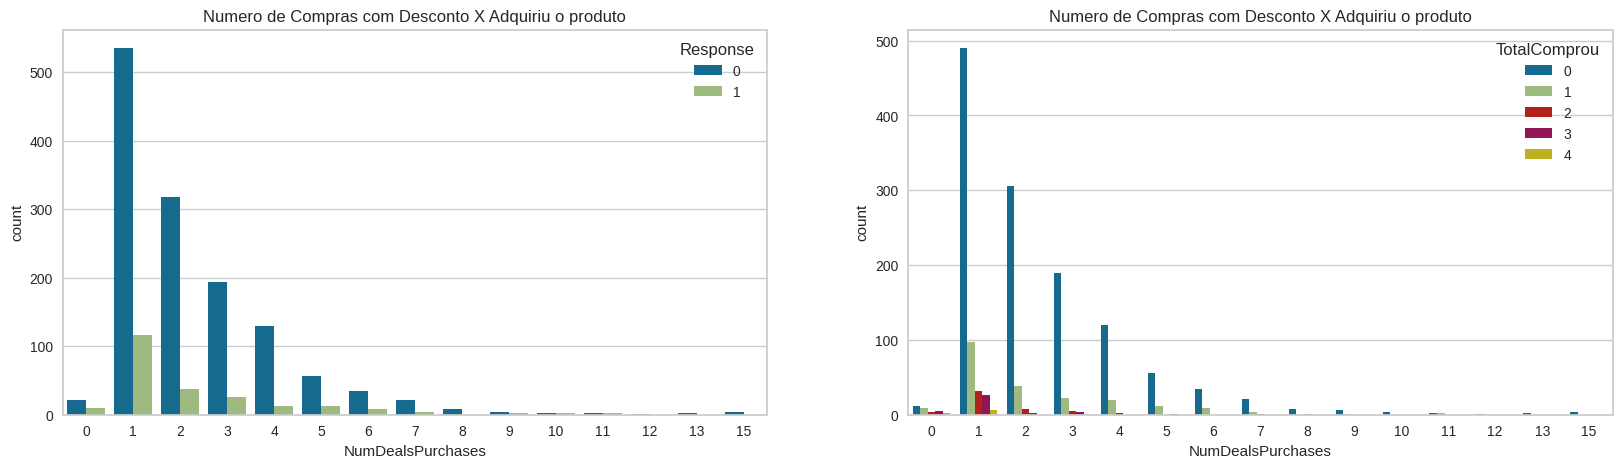

In [376]:
#visualizando o numero de compras feita com desconto com o fato de ter adquirido o produto 
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.countplot(x='NumDealsPurchases', hue='Response', data=df_train)
plt.title('Numero de Compras com Desconto X Adquiriu o produto')

#numero de compras com desconto x total Comprou 
plt.subplot(1,2,2)
sns.countplot(x='NumDealsPurchases', hue='TotalComprou', data=df_train)
plt.title('Numero de Compras com Desconto X Adquiriu o produto')

Aparentemente o cliente ter comprado mais produtos com desconto não o faz ser mais responsivo a campanha do novo produto. 

In [377]:
# Transforma a coluna Dt_Customer em um objeto datetime
df_train['Dt_Customer'] = pd.to_datetime(df_train['Dt_Customer'])

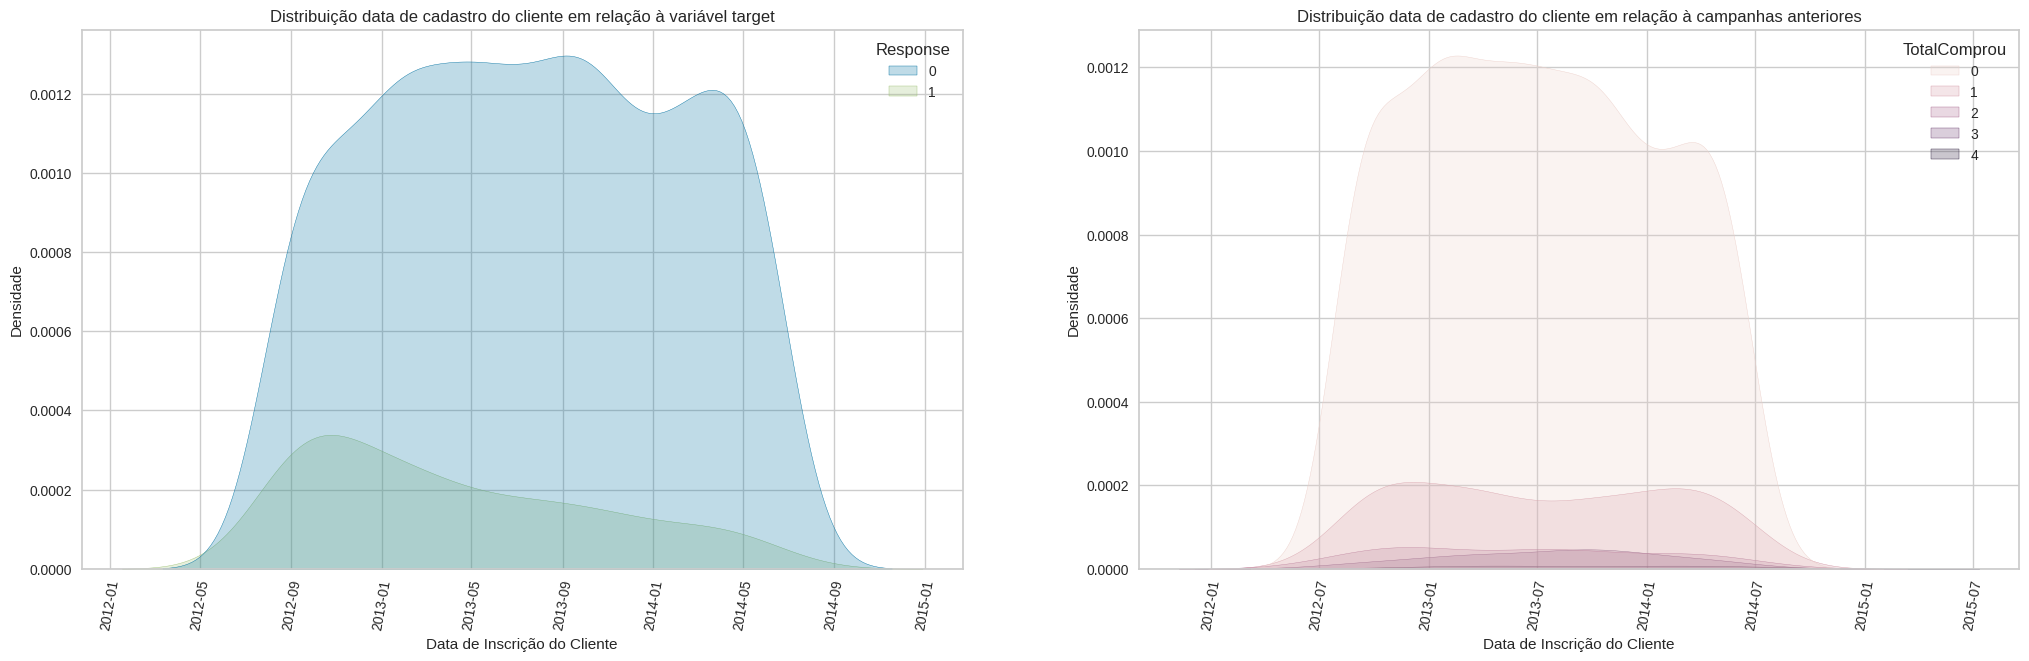

In [378]:
#"Distribuição data de cadastro do cliente em relação à campanhas
plt.figure(figsize=(25,7))
plt.subplot(1,2,1)
sns.kdeplot(data=df_train, x="Dt_Customer", hue="Response", fill=True)
plt.title("Distribuição data de cadastro do cliente em relação à variável target")
plt.xlabel("Data de Inscrição do Cliente")
plt.ylabel("Densidade")
plt.xticks(rotation =80)

plt.subplot(1,2,2)
sns.kdeplot(data=df_train, x="Dt_Customer", hue="TotalComprou", fill=True)
plt.title("Distribuição data de cadastro do cliente em relação à campanhas anteriores")
plt.xlabel("Data de Inscrição do Cliente")
plt.ylabel("Densidade")
plt.xticks(rotation =80)
plt.show()

Quando eu olho para minha variavel target, aparentemente os clientes que responderam a campanha tendem a ser clientes mais antigos e quanto mais novo o cliente menor a chance dele responder a campanha de marketing. 
Quando eu olho as pessoas que responderam as campanhas anteriores existe essa relação porem ela e menos evidente.

Text(0.5, 1.0, 'Distribuição da data de nascimento ')

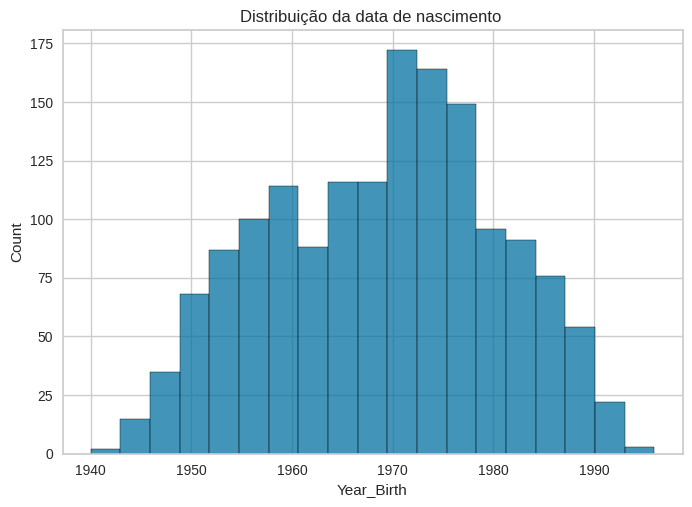

In [379]:
#visualizando a distribuição da data de nascimento 
sns.histplot(df_train.Year_Birth)
plt.title('Distribuição da data de nascimento ')

In [380]:
#deletando as 2 linhas outliers de data de nascimento 
df_train.drop(df_train[df_train.Year_Birth <= 1900].index,inplace = True)

# Criando uma feature que diz a idade do cliente
df_train["Age"] = 2023 - df_train["Year_Birth"]


Eu havia notado outliers com ano de nascimento menor que 1900 porem apos colocar uma divisão do conjunto de dados estratificada esses dados ficaram apenas no conjunto de teste, irei deixar a tratativa presente de remoção de outliers com ano menor que 1900 e replicar no conjunto de teste.

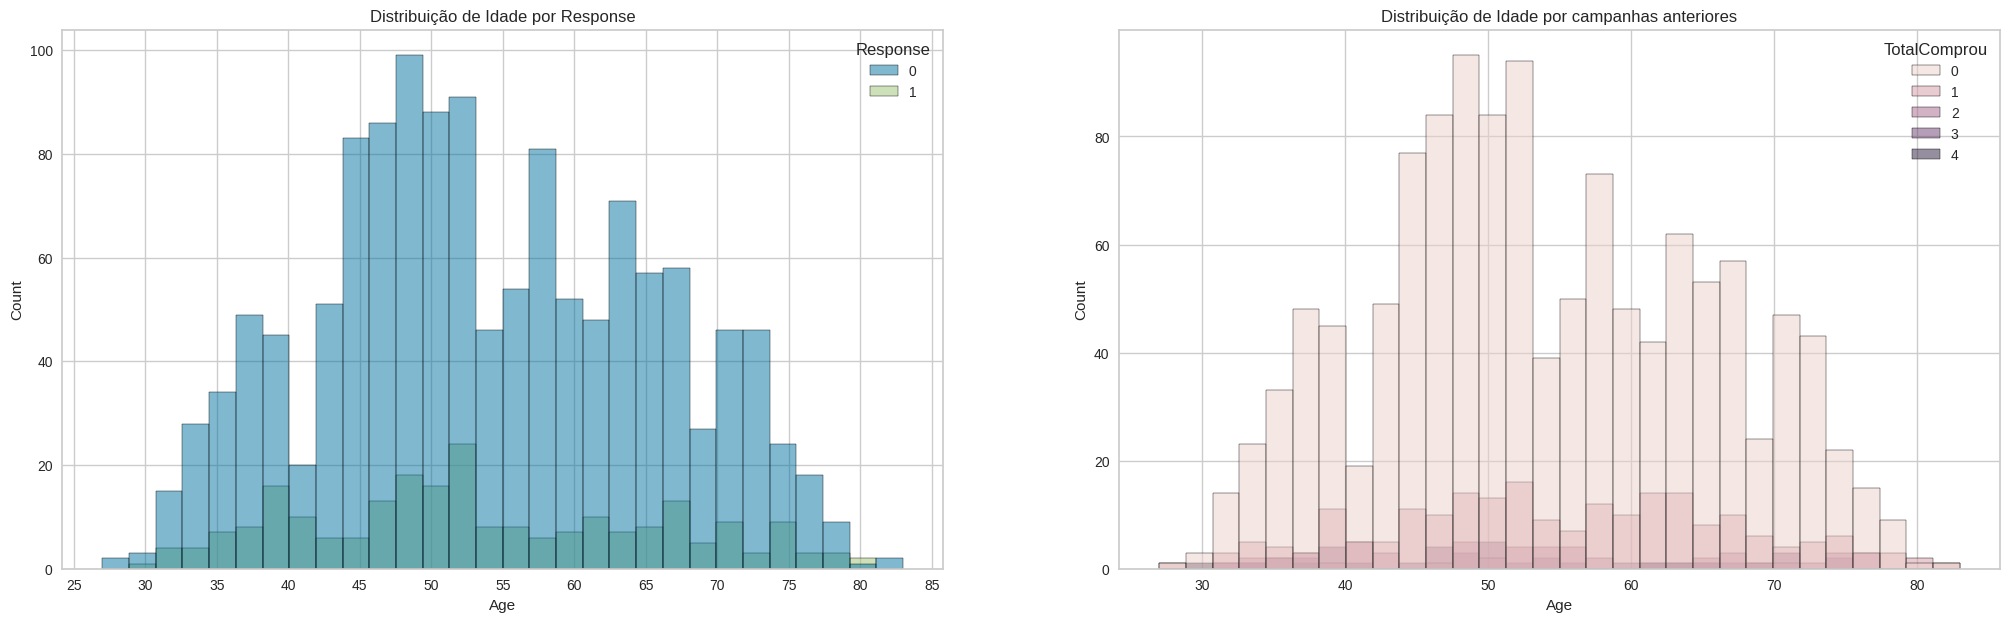

In [381]:
#visualizando a distribuição de idade de quem respondeu a campanha 
plt.figure(figsize=(25,7))
plt.subplot(1,2,1)
sns.histplot(data=df_train, x='Age', hue='Response', kde=False, bins=30)
plt.title('Distribuição de Idade por Response')
plt.xticks(range(25, 90, 5))
plt.subplot(1,2,2)
sns.histplot(data=df_train, x='Age', hue='TotalComprou', kde=False, bins=30)
plt.title('Distribuição de Idade por campanhas anteriores')
plt.show()

olhando a distribuição de idade de quem adquiriu o produto, podemos perceber que a distribuição e quase uniforme com alguns picos em determinadas faixas de idade. 

##Pre-Processamento para modelagem

#### Dados nulos


In [382]:
#verificando os dados nulos 
df_train.isnull().mean()[df_train.isnull().mean() > 0].sort_values(ascending=False)


Income    0.009566
dtype: float64

In [383]:
#dropando as linhas com valores nulos em Income
df_train.dropna(subset=['Income'], inplace=True)

Eu encontrei poucas linhas com valores nulos em Income, eu tentei uma inputação pegando o nivel de educação do cliente e inputando pela media de Income daquele nivel, porem os resultados na modelagem não foram muito bons então optei por remover. 

#### Dropando colunas que não pretendo usar a principio 

In [384]:
#fazendo um backup do df_train
copy_df_train = df_train.copy()

In [385]:
#Dropando colunas que não pretendo usar 
df_train = df_train.drop(['Year_Birth','Z_Revenue','Z_CostContact','ID',],axis = 1)

- Estou removendo **year_birth** por que criei a feature Age 
- **z_Revenue** e **Z_costContact**, Ambas representam o custo por contato e o retorno caso o cliente compre o produto, porem elas não possuem variabilidade que justifique manter elas. 


#### Ajustando dados das variaveis categoricas 

In [386]:
#tratando os dados da variavel Marital_Status
df_train.Marital_Status = df_train.Marital_Status.replace('Together', 'Married')
df_train.Marital_Status = df_train.Marital_Status.replace('Alone', 'Single')
df_train.drop(df_train[df_train.Marital_Status =='Absurd'].index, inplace = True)
df_train.drop(df_train[df_train.Marital_Status =='YOLO'].index, inplace = True)

Aqui os valores em marital status como Together e Alone eu coloquei em Casado e solteiro, porem valores como absurd e Yolo eu optei por remover pois eram poucas linhas e não é possivel uma auto dedução. 

In [387]:
#checando os valores de Marital_status
df_train.Marital_Status.value_counts()

Married     1013
Single       326
Divorced     159
Widow         53
Name: Marital_Status, dtype: int64

In [388]:
'''cat_cols = ["Kidhome", "Teenhome", "AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4",
         "AcceptedCmp5","Education", "Marital_Status", "Complain"]

num_cols = [col for col in df_train.select_dtypes(include=np.number).columns if col not in cat_cols]
'''

'cat_cols = ["Kidhome", "Teenhome", "AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4",\n         "AcceptedCmp5","Education", "Marital_Status", "Complain"]\n\nnum_cols = [col for col in df_train.select_dtypes(include=np.number).columns if col not in cat_cols]\n'

#### Preparando os dados para modelagem baseline 

In [389]:
#pegando o nome das features numericas 
numeric_cols = df_train.select_dtypes(include=[np.number]).columns

In [390]:
df_train_outliers = df_train.copy()
#Removendo outliers do conjunto de treinamento 
df_train_no_outliers = remove_outliers(df_train,3)

#Convertendo o array retornado pela função em um dataFrame novamente e passando o nome das colunas. 
df_train_no_outliers = pd.DataFrame(df_train_no_outliers, columns=df_train.columns)
df_train_no_outliers[numeric_cols] = df_train_no_outliers[numeric_cols].astype(int)
df_train = df_train_no_outliers.copy()

Estou removendo outliers com base em uma função que calcula a distancia de mahalanobis para cada linha, em seguida ele compara se a linha é maior que o tresholds que é o calculo do segundo parametro, mais a media de valor daquela feature multiplicado pelo desvio padrão, caso seja maior ele considera aquele dado como outlier e remove o mesmo. 
- Ou seja passar valores mais altos no segundo parametro ira considerar mais dados como outliers, enquanto passar valores mais baixos tera o efeito inverso. 

In [391]:
#fazendo one hot nas variaveis categoricas para o modelo baseline
df_train_baseline = pd.get_dummies(df_train, columns=['Education','Marital_Status'], drop_first=True)

In [392]:
#separando os dados da variavel target em X e y
X = df_train_baseline.drop(['Response','Dt_Customer'], axis = 1)
y = df_train_baseline['Response']

In [393]:
#divindo em treino e validação baselines 
X_train_baseline, X_val_baseline, y_train_baseline, y_val_baseline = train_test_split(X, y,  test_size =0.3,random_state = 1603)

In [394]:
#verificando a quantidade de dados em X_train e X_val baseline 
X_train_baseline.shape, X_val_baseline.shape

((1067, 30), (458, 30))

## Baseline Model

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       393
           1       0.52      0.18      0.27        65

    accuracy                           0.86       458
   macro avg       0.70      0.58      0.60       458
weighted avg       0.83      0.86      0.83       458



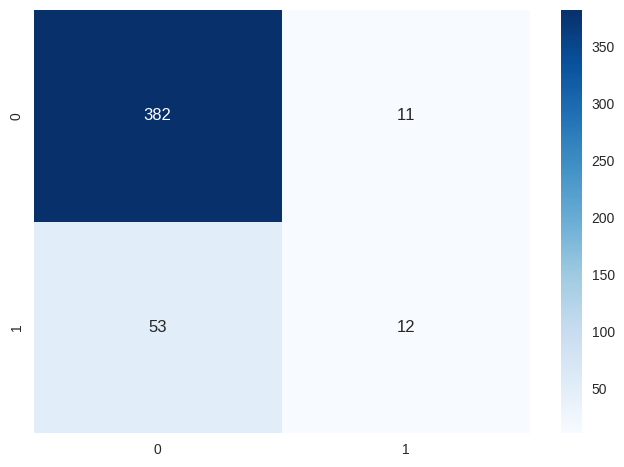

In [395]:
#instanciando o modelo baseline De regressão logistica
LR_model = LogisticRegression(random_state=1603, solver='liblinear').fit(X_train_baseline, y_train_baseline)
y_pred_train_LR_baseline = LR_model.predict(X_val_baseline)


# Report das metricas
print(classification_report(y_val_baseline, y_pred_train_LR_baseline))
#criando a matriz de confusão
ax = sns.heatmap(confusion_matrix(y_val_baseline, y_pred_train_LR_baseline),
                 annot=True,
                 fmt = 'd',
                 cmap = 'Blues')


Eu resolvi criar um modelo Baseline para ter um ponto de partida e saber o quanto o Featuare Engineering, Normalização, Clusterização entre outras tecnicas podem melhorar minhas metricas 
- Eu vou optar por priorizar o **Recall** acredito que seja a metrica mais viavel para este problema uma vez que o retorno do cliente que compra o produto é quase 4x o custo para contatalo. 

## Feature Engineering

In [396]:
#criando uma coluna que conta o numero total de filhos.
df_train['N_Filhos'] = df_train.Teenhome + df_train.Kidhome

Estou criando uma feature numero de Filhos que representa a soma dos filhos(criança + adolescente)

In [397]:
#criando uma feature chamada ProdutosTotais, que representa o numero total de produtos comprados 
df_train['ProdutosTotais'] = df_train[['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts',]].sum(axis=1)

#Criando a feature ComprasTotal que representa o numero total de compras efetuadas 
df_train['ComprasTotal'] = df_train[['NumCatalogPurchases','NumStorePurchases','NumWebPurchases','NumDealsPurchases']].sum(axis=1)


Estou criando duas features importantes que irei usar para criação de outras features.
- **ProdutosTotais** representa o numero total de produtos comprados, pode ser entendido como poder de aquisição de um cliente, valores mais altos podem indicar um cliente que gasta mais. 
- **ComprasTotal** representa o numero total de compras, aqui é a frequencia que um cliente compra, valores mais altos indicam que este é um cliente que compra com alta frequencia. 

In [398]:
#função para contar o numero de dias apartir de DT_customer
import datetime
def totalDays(inscricao):
    data_atual = datetime.datetime(2023, 5, 3)
    data_inscricao = datetime.datetime.strptime(inscricao.strftime('%Y-%m-%d'), '%Y-%m-%d')
    num_days = (data_atual - data_inscricao).days
    return num_days

In [399]:
#criando uma coluna contendo o numero de dias que o cliente se inscreveu.
df_train['Num_dias'] = df_train['Dt_Customer'].apply(totalDays)

Essa feature DT_customer apresenta uma boa correlação com a variavel target, onde clientes mais antigos são mais propoensos a adquirir o produto, uma forma de usar ela foi calcular o numero de dias com base na data atual, onde valores mais altos indicam um cliente mais antigo e com maiores chances de adquirir o produto segundo a analise exploratoria.  

In [400]:
#função que calcula a porcentagem 
def calc_porcent(x, y):
    return (x / y) if y != 0 else 0

In [401]:
#criando colunas de porcentagem de compras por cada plataforma
df_train['Store %'] = df_train.apply(lambda row: calc_porcent(row['NumStorePurchases'], row['ComprasTotal']),axis=1)
df_train['Web %'] = df_train.apply(lambda row: calc_porcent(row['NumWebPurchases'], row['ComprasTotal']),axis=1)
df_train['Catalog %'] = df_train.apply(lambda row: calc_porcent(row['NumCatalogPurchases'], row['ComprasTotal']),axis=1)
#criando colunas de porcentagem de compras de cada produto. 
df_train['Wines %'] = df_train.apply(lambda row: calc_porcent(row['MntWines'], row['ProdutosTotais']),axis=1)
df_train['Meat %'] = df_train.apply(lambda row: calc_porcent(row['MntMeatProducts'], row['ProdutosTotais']),axis=1)
df_train['Fish %'] = df_train.apply(lambda row: calc_porcent(row['MntFishProducts'], row['ProdutosTotais']),axis=1)
df_train['Sweet %'] = df_train.apply(lambda row: calc_porcent(row['MntSweetProducts'], row['ProdutosTotais']),axis=1)
df_train['Fruits %'] = df_train.apply(lambda row: calc_porcent(row['MntFruits'], row['ProdutosTotais']),axis=1)
df_train['GoldProds %'] = df_train.apply(lambda row: calc_porcent(row['MntGoldProds'], row['ProdutosTotais']),axis=1)

#criando coluna GastoRenda proporção de gasto em relação a renda *
df_train['GastoRenda'] = df_train.apply(lambda row: calc_porcent(row['ProdutosTotais'], row['Income']*2),axis=1)

#criando a coluna GastoCompra que armazena o gasto por compra de cada cliente. 
df_train['GastoCompra'] =df_train.apply(lambda row: calc_porcent(row['ProdutosTotais'], row['ComprasTotal']),axis=1)


Aqui é onde eu uso as Features que criei anteriormente que representavam a quantidade de compras de um cliente(Frequencia) e a quantidade de produtos comprados(Maior Gasto).
- Estou criando as features que representam a % de compras feitas por plataforma de vendas (Loja , Site, Catalogo)
- Estou criando as features que representão a % de cada tipo de produto comprado com base no numero total de produtos comprados(Vinhos, Carnes, peixes, doces, frutas e goldProdutos)
- GastoRenda e GastoCompra representam a proporção de gastos feitas com relação a renda e o gasto efetuado por compra por cada cliente. 


### Segmentação demografica 

#### Grupos por renda

In [402]:
#verificando a distribuição dos quartils de renda.
df_train.Income.describe()

count     1525.000000
mean     51650.291803
std      20475.811648
min       4861.000000
25%      35340.000000
50%      51267.000000
75%      68627.000000
max      93874.000000
Name: Income, dtype: float64

In [403]:
#Segmentação por renda

df_train['Faixas_Income'] = pd.cut(df_train['Income'], bins=[0,np.percentile(df_train.Income, 25),np.percentile(df_train.Income, 50), np.percentile(df_train.Income, 75), np.inf], labels=[0,1,2,3]).astype('Int64')


Estou criando grupos de Faixas de renda, com base nos quartis, e irei verificar se existe uma diferença significativa entre esses grupos com base em um teste estatistico. 

In [404]:
#criando uma lista de todas as faixas de renda
faixas = [0, 1, 2, 3]

#gerando todas as combinações possíveis de 2 faixas de renda
combinacoes = itertools.combinations(faixas, 2)

#iterando sobre as combinações e executando o teste U para cada par de faixas de renda
for combinacao in combinacoes:
    grupo1 = df_train[df_train['Faixas_Income'] == combinacao[0]]
    grupo2 = df_train[df_train['Faixas_Income'] == combinacao[1]]

    stat, p = mannwhitneyu(grupo1['TotalComprou'], grupo2['TotalComprou'])
    if p < 0.05:
        print(f"Existe uma diferença significativa entre os grupos {combinacao[0]} e {combinacao[1]} então rejeitamos a hipotese nula com (p-valor={p})")
    else:
        print(f"Não existe uma diferença significativa entre os grupos {combinacao[0]} e {combinacao[1]} então aprovamos a hipotese nula  com (p-valor={p})")


Existe uma diferença significativa entre os grupos 0 e 1 então rejeitamos a hipotese nula com (p-valor=0.039470779083831856)
Existe uma diferença significativa entre os grupos 0 e 2 então rejeitamos a hipotese nula com (p-valor=1.4215487087703827e-05)
Existe uma diferença significativa entre os grupos 0 e 3 então rejeitamos a hipotese nula com (p-valor=1.1895861678638796e-27)
Existe uma diferença significativa entre os grupos 1 e 2 então rejeitamos a hipotese nula com (p-valor=0.018849537387954113)
Existe uma diferença significativa entre os grupos 1 e 3 então rejeitamos a hipotese nula com (p-valor=6.267760714232599e-21)
Existe uma diferença significativa entre os grupos 2 e 3 então rejeitamos a hipotese nula com (p-valor=7.850203001119016e-14)


Eu ja tinha visualizado que existia essa diferença na analise exploratoria porem quis fazer o teste de hipotese para validar a criação dessa feature. 
- Optei por usar o **teste U** que é um teste não parametrico e considera que não existe uma distribuição normal nos grupos oque é o meu caso. 

- Eu também testei com **ComprasTotal** e **ProdutosTotais** e ambos rejeitaram a hipotese nula. 

####Grupos por nivel de escolaridade 

In [405]:
#criando os grupos de escolaridade
mapeamento = {'Basic': 0,
              '2n Cycle': 1,
              'Graduation': 2,
              'Master': 2,
              'PhD': 2}

df_train['Nivel_Escolaridade'] = df_train['Education'].map(mapeamento)

Estou criando niveis de escolaridade, apos algumas combinações e testar elas com o teste de hipotese abaixo, percebi que a melhor forma de segmentar esses grupos era com base em 3 niveis de ensino(basico, medio, e superior)

In [406]:
#criando uma lista de todas as faixas de renda
faixas = [0, 1, 2]

#gerando todas as combinações possíveis de 2 faixas de renda
combinacoes = itertools.combinations(faixas, 2)

#iterando sobre as combinações e executando o teste U para cada par de faixas de renda
for combinacao in combinacoes:
    grupo1 = df_train[df_train['Nivel_Escolaridade'] == combinacao[0]]
    grupo2 = df_train[df_train['Nivel_Escolaridade'] == combinacao[1]]

    stat, p = mannwhitneyu(grupo1['ComprasTotal'], grupo2['ComprasTotal'])
    if p < 0.05:
        print(f"Existe uma diferença significativa entre os grupos {combinacao[0]} e {combinacao[1]} então rejeitamos a hipotese nula com (p-valor={p})")
    else:
        print(f"Não existe uma diferença significativa entre os grupos {combinacao[0]} e {combinacao[1]} então aprovamos a hipotese nula  com (p-valor={p})")


Existe uma diferença significativa entre os grupos 0 e 1 então rejeitamos a hipotese nula com (p-valor=1.1993314592347673e-07)
Existe uma diferença significativa entre os grupos 0 e 2 então rejeitamos a hipotese nula com (p-valor=5.352004157470167e-12)
Existe uma diferença significativa entre os grupos 1 e 2 então rejeitamos a hipotese nula com (p-valor=0.013718742855634864)


Eu escolhi dividir os niveis de escolaridade em 3 niveis. basico, médio, e superior, segundo o teste de hipotese existe diferenças entre esses grupos, e na modelagem se mostrou um melhor resultado. 

### RFM

**RFM** é uma técnica de análise de dados usada para segmentar clientes com base em seu comportamento de compra. Essa técnica divide os clientes em três dimensões:

- **Recência (R):** o tempo desde a última compra do cliente;
- **Frequência (F):** a frequência de compras do cliente em um determinado período de tempo;
- **Monetaridade (M):** o valor total gasto pelo cliente em um determinado período de tempo.

A partir dessas três dimensões, os clientes podem ser segmentados em grupos com base em seu comportamento de compra. Por exemplo, clientes que fizeram compras recentes, com alta frequência e alto valor de compra seriam considerados clientes VIP, enquanto clientes que fizeram compras há muito tempo, com baixa frequência e baixo valor de compra podem ser considerados clientes inativos.

#### Recency

In [407]:
#Criando grupos de Recency 
df_train['Recency_compra'] = pd.cut(df_train['Recency'],bins=[-1,np.percentile(df_train.Recency, 25),np.percentile(df_train.Recency, 50), np.percentile(df_train.Recency, 75), np.inf], 
                                    labels=[3, 2, 1, 0]).astype("Int64")


Aqui a labels esta invertida diferente de **Frequency** e **Monetary** aqui a pontuação mais alta e referente ao menor valor de Recency pois estou interessado no cliente que acessou o site em um menor tempo de dias.

In [408]:
#verificando a distribuição dos grupos 
df_train.Recency_compra.value_counts()

2    396
3    382
0    376
1    371
Name: Recency_compra, dtype: Int64

#### Frequency

In [409]:
#criando os grupos de frequencia com base nos quartils de CompraTotal
df_train['freq_compra'] = pd.cut(df_train['ComprasTotal'], bins=[-1,np.percentile(df_train.ComprasTotal, 25),np.percentile(df_train.ComprasTotal, 50), np.percentile(df_train.ComprasTotal, 75), np.inf], 
                                  labels=[0, 1, 2, 3]).astype("float").astype("Int64")


- Em um mundo ideal eu teria uma feature com as datas das compras para calcular a frequencia, porem como não tenho estou utilizando  a feature que representa a soma do numero total de compras, inplicando que quanto mais compras o cliente tem maior a frequencia. 

In [410]:
#verificando a distribuição dos grupos 
df_train.freq_compra.value_counts()

0    433
2    396
3    351
1    345
Name: freq_compra, dtype: Int64

#### Monetary

In [411]:
#criando  os grupos de Monetary com base nos quatis de ProdutosTotais
df_train['Monetary'] = pd.cut(df_train['ProdutosTotais'], bins=[-1, np.percentile(df_train.ProdutosTotais, 25),np.percentile(df_train.ProdutosTotais, 50), np.percentile(df_train.ProdutosTotais, 75), np.inf], 
                                  labels=[0, 1, 2, 3]).astype("int")

Para criar os grupos de Monetary estou utilizando a feature ProdutosTotais que representa a quantidade total de produtos comprados por um cliente, quantos mais produtos comprados maior o poder monetario do cliente, novamente em um mundo ideal eu teria o valor dos produtos e poderia calcular de forma mais exata. 

In [412]:
#verificando a distribuição dos grupos 
df_train.freq_compra.value_counts()

0    433
2    396
3    351
1    345
Name: freq_compra, dtype: Int64

#### RFM Score

In [413]:
#criando o RFM Score que é a soma de Recency+Frequency+monetary
df_train['RFM_Score'] = df_train.Recency_compra + df_train.freq_compra + df_train.Monetary

In [414]:
#visualizando a soma de RFM_Sceore
df_train[['Recency_compra','freq_compra','Monetary','RFM_Score']]

,Recency_compra,freq_compra,Monetary,RFM_Score
0,1,1,1,3
1,2,2,1,5
2,0,3,3,6
3,2,3,2,7
4,1,0,0,1
...,...,...,...,...
1520,1,1,1,3
1521,0,0,0,0
1522,1,2,1,4
1523,1,1,2,4


Como ja tinha dito com base em Recency, Frequency e Moneray e possivel saber se o cliente é de alto valor ou um cliente inativo, uma forma de facilitar essa compreensão e a feature RFM score, onde valores mais altos indicam um cliente VIP.

##Clustering


In [415]:
#removendo colunas que não vou mais usar. 
df_train = df_train.drop(['Dt_Customer'],axis = 1)

In [416]:
#fazendo one hot nas variaveis categoricas para o modelo 
df_train_final = pd.get_dummies(df_train, columns=['Marital_Status','Education'], drop_first=True)

In [417]:
#realizando um backup e removento a feature target da clusterização. 
cluster_df = df_train_final.copy()
cluster_df.drop('Response',axis =1,inplace = True)

In [418]:
#Fazendo o escalonamento dos dados antes de aplicar o PCA. 

clust_scaler = StandardScaler()
df_STD = pd.DataFrame(clust_scaler.fit_transform(cluster_df))

#aplicando o PCA 
pca = PCA(n_components=3)
df_PCA = pca.fit_transform(df_STD)

Aqui eu testei com 2 componentes porem tive um desempenho melhor com 3. 

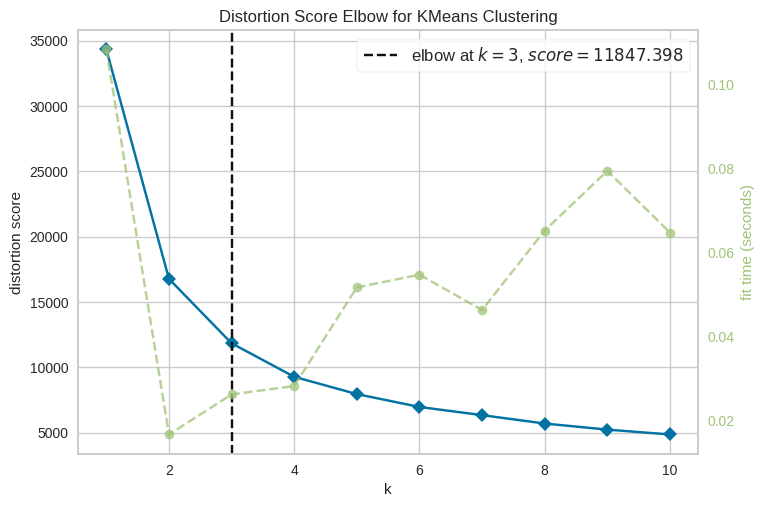

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [419]:
# Inicializando o modelo KMeans
model = KMeans(random_state=1603)

# Inicializando o visualizador KelbowVisualizer
visualizer = KElbowVisualizer(model, k=(1, 11))

# Ajustando o visualizador aos dados
visualizer.fit(df_PCA)

# Plotando o gráfico do método Elbow
visualizer.show()


Estou utilizando a função KElbowVisualizer para encontrar o melhor numero de clusters com o metodo Elbow, ela também exibe o tempo de treino para cada numero de clusters. 

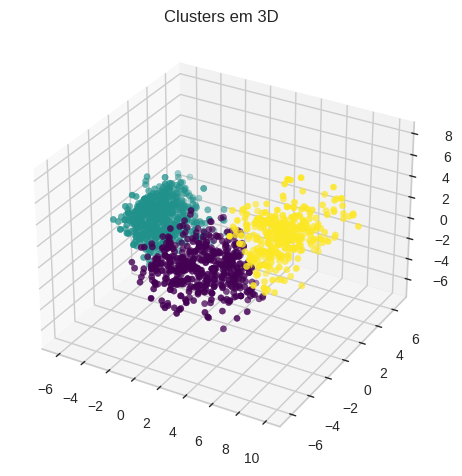

In [420]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Criar modelo KMeans com o número desejado de clusters
k = 3
kmeans = KMeans(n_clusters=k)
kmeans.fit(df_PCA)

# Obter os rótulos dos clusters
labels = kmeans.labels_

# Criar figura 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# Plotar os pontos de dados coloridos pelos rótulos dos clusters
ax.scatter(df_PCA[:, 0], df_PCA[:, 1], df_PCA[:, 2], c=labels, cmap='viridis')

ax.set_title('Clusters em 3D')

# Mostrar gráfico
plt.show()


Como possuo 3 grupos estou visualizando a distribuição dos clusters em um plano 3D.

###### criando o clusters

In [421]:
# Coordenadas dos centroides iniciais para não ficar alterando a cada execução. 
initial_centroids = np.array([[5.04005368,1.54625283,0.66752786],
 [1.24792457,-1.86999407,-1.03002757],
 [-3.63325521,0.49738126,0.37410458]]) 

# K-means clustering para segmentação de clientes (k = 3)
km = KMeans(n_clusters=3, random_state=1603, init=initial_centroids)
km.fit(df_PCA)
predict = km.predict(df_PCA)

'''# Adicionando as colunas de grupos como dummies
cluster_dummies = pd.get_dummies(predict, prefix='Cluster', drop_first=True)
df_train_final = pd.concat([df_train_final, cluster_dummies], axis=1)
'''

"# Adicionando as colunas de grupos como dummies\ncluster_dummies = pd.get_dummies(predict, prefix='Cluster', drop_first=True)\ndf_train_final = pd.concat([df_train_final, cluster_dummies], axis=1)\n"

Eu estou imputando as cordenadas dos clusters para que eles não se alterem a cada execução do codigo, dificultando as minhas anotações, é praticamente a mesma função do random_state que para minha surpresa não faz mantem estatico a incialização dos clusters. 

### Inspecionando os Grupos

In [422]:
#criando a feature cluster que contem o grupo que cada cliente pertence 
df_train_final['Cluster'] = predict
#visualizando a mediana de algumas features por cada grupo 
feature_columns = ["Recency", "ComprasTotal", "ProdutosTotais","N_Filhos", "Income", "Age","Faixas_Income", "Nivel_Escolaridade","Marital_Status_Married","Marital_Status_Single","NumDealsPurchases","TotalComprou"]
df_train_final.groupby("Cluster")[feature_columns].agg("mean").round(2)


,Recency,ComprasTotal,ProdutosTotais,N_Filhos,Income,Age,Faixas_Income,Nivel_Escolaridade,Marital_Status_Married,Marital_Status_Single,NumDealsPurchases,TotalComprou
Cluster,,,,,,,,,,,,
0,50.13,20.49,1349.18,0.18,76237.86,53.59,2.81,1.91,0.61,0.25,1.19,0.78
1,46.48,20.68,637.27,1.19,57434.87,57.95,1.84,1.95,0.69,0.14,3.72,0.21
2,49.32,7.66,75.84,1.23,34267.12,51.15,0.55,1.77,0.65,0.24,1.94,0.08


- É possivel perceber que os clientes do **grupo 0** são clientes de **Alto Valor** que compram com uma **Alta Frequencia** e Compram grandes quantidades e respondem mais as camapanhas de marketing.  
- Já os clientes do **Grupo 1**, podem ser considerados de **Medio valor** apesar deles comprarem com uma **Alta Frequencia** eles compram menos quantidades, e respondem menos as campanhas de marketing. 
-Os clientes do **Grupo 2**, podem ser considerados de **Baixo Valor**, eles compram com uma **Baixa Frequencia** e poucas quantidades, eles também não respondem as campanhas de marketing.  


In [423]:
#adicionando marital e ajustando cluster para plots.
df_train_final['Marital'] = df_train['Marital_Status']
df_train_final['Cluster'] = df_train_final['Cluster'].astype('category')
#reservando o conjunto com Response == 1 para os plots 
filtered_df = df_train_final[df_train_final['Response'] == 1]

Text(0.5, 1.0, 'Distribuição da feature Target por Grupos de clientes')

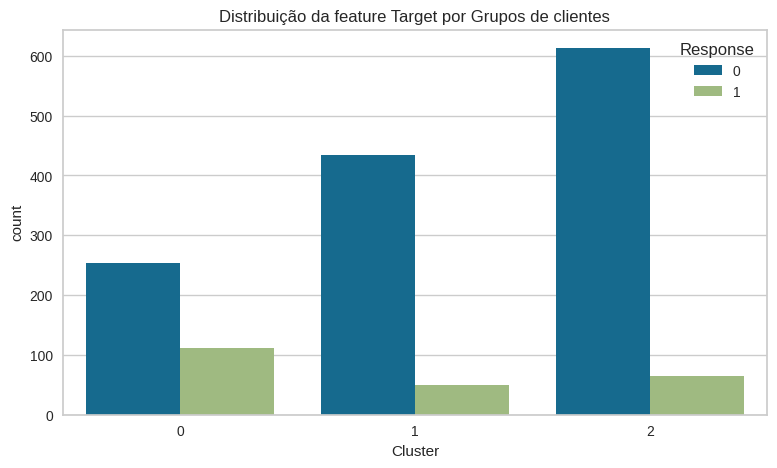

In [424]:
#visualizando a distribuição da variavel target dos grupos criados. 
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.countplot(x='Cluster', hue='Response', data=df_train_final)
plt.title('Distribuição da feature Target por Grupos de clientes')

Apesar dos clientes do **Grupo 2** serem os clientes que menos compram, eles representam o maior Grupo, é importante notar também que a soma dos respondentes da campanha de marketing do **Grupo 1 e 2** se equipara aos respondentes do **Grupo 0** 

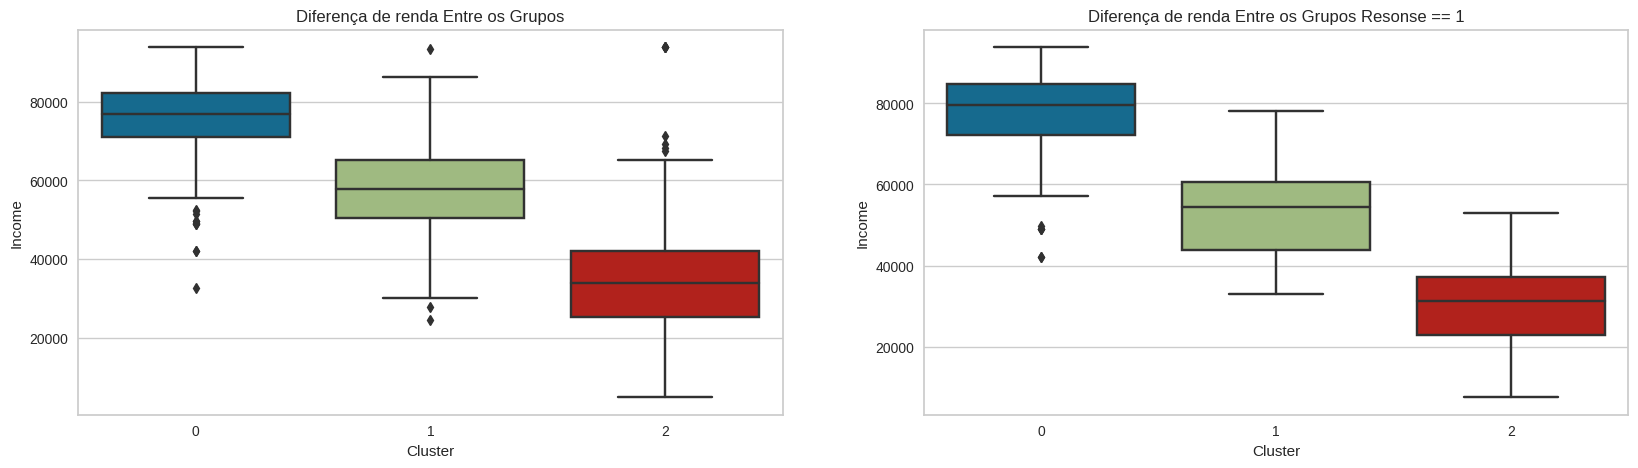

In [425]:
#visualizando a diferença de renda entre os grupos 
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.boxplot(x="Cluster", y="Income", data=df_train_final)
plt.title('Diferença de renda Entre os Grupos')

plt.subplot(1,2,2)
sns.boxplot(x="Cluster", y="Income", data=filtered_df)
plt.title('Diferença de renda Entre os Grupos Resonse == 1')
plt.show()

Novamente e possivel notar que a renda é um fator decisivo no comportamente de compra do cliente, onde o **Grupo 0** que possui a maior renda é o que mais compra, tendo em **media 76237.86** de renda. 

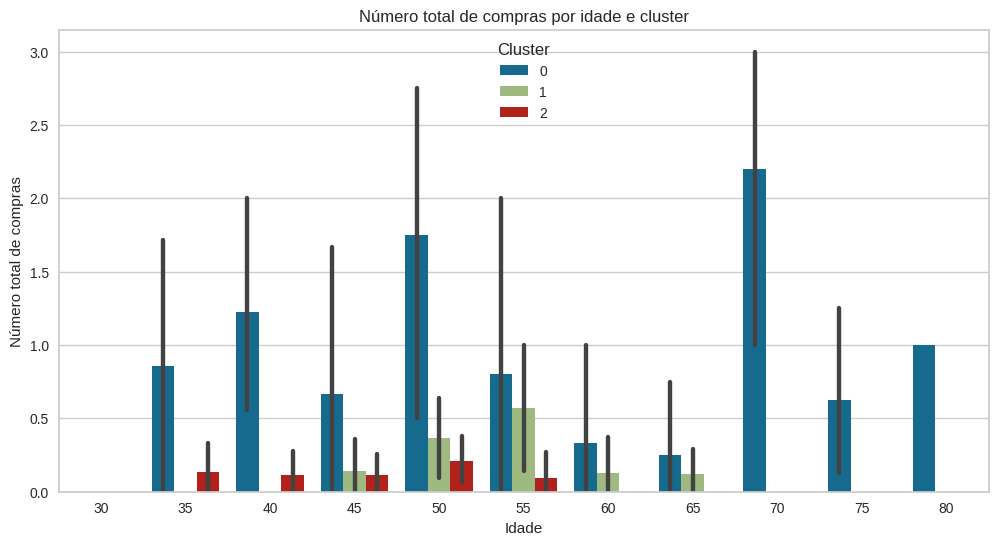

In [426]:
# Definindo a ordem dos valores no eixo x (Age)
age_order = range(30, df_train_final['Age'].max()+1, 5)

# Criando o gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x='Age', y='TotalComprou', hue='Cluster', data=df_train_final, order=age_order)
plt.title('Número total de compras por idade e cluster')
plt.xlabel('Idade')
plt.ylabel('Número total de compras')
plt.show()


- O Grupo 0 esta presente em todas as faixas de idade sendo o unico grupo com clientes compradores com mais de 65 anos, clientes estes que possuem uma alta taxa de resposta a campanhas da campanha de marketing.  
- As pessoas do Grupo 1 que responderam as campanhas estão entre 45 e 65 anos e compraram em media apenas um produto 
- As pessoas que compraram o produto e pertencem ao Grupo 2, são pessoas mais jovens e compraram em media apenas 1 produto.  

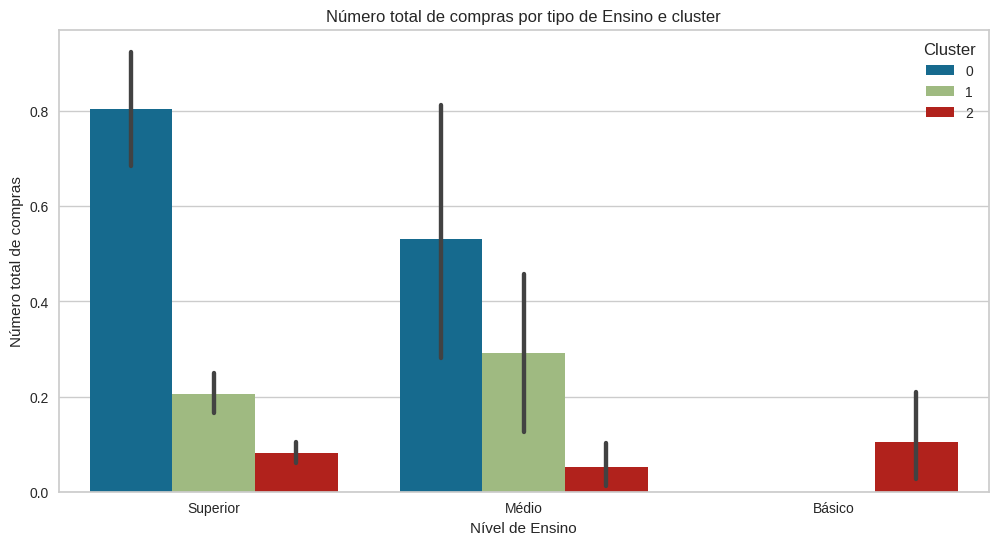

In [427]:
#Criando o gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x=df_train_final['Nivel_Escolaridade'].replace({0: 'Básico', 1: 'Médio', 2: 'Superior'}), y='TotalComprou', hue='Cluster', data=df_train_final)
plt.title('Número total de compras por tipo de Ensino e cluster')
plt.xlabel('Nível de Ensino')
plt.ylabel('Número total de compras')
plt.show()


- Somente o Grupo 2 possui clientes com nivel basico de ensino.
- A maioria dos Clientes do Grupo 1 possui ensino medio 
- A maioria dos clientes do Grupo 0 possuem ensino superior. 

O grupo 0 em sua maioria possui ensino superior. 

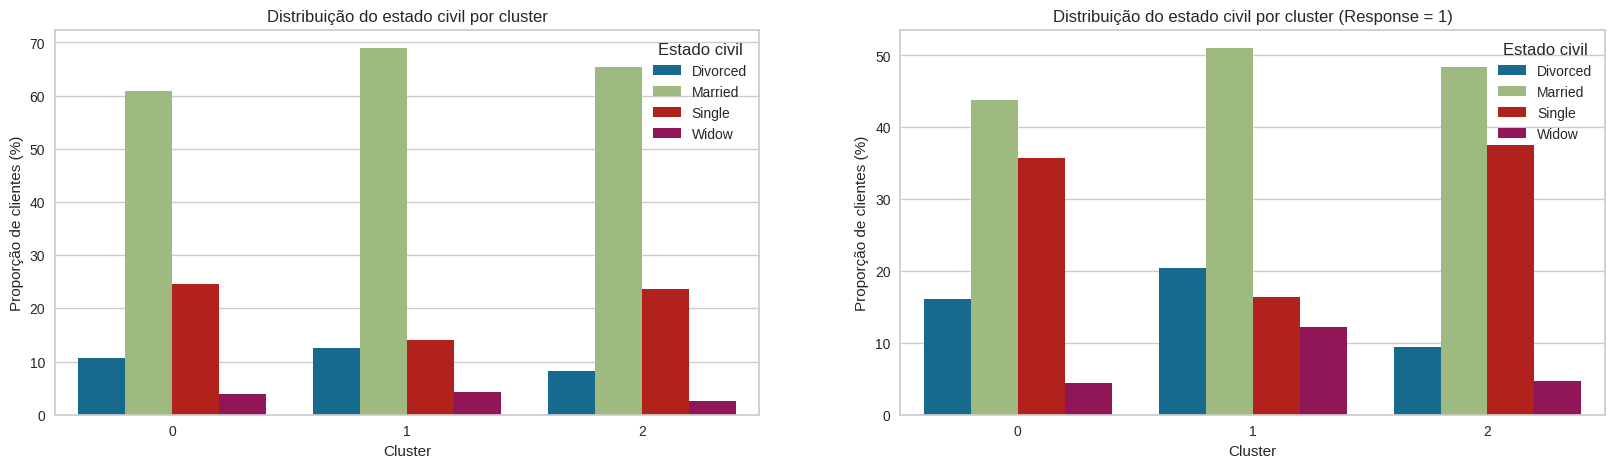

In [428]:

# Calcula as proporções de cada estado civil em cada cluster
prop_df = df_train_final.groupby(['Cluster', 'Marital']).size().reset_index(name='Count')
prop_df['Proportion'] = prop_df.groupby('Cluster')['Count'].apply(lambda x: x / x.sum() * 100)

# Plota o gráfico de 
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.barplot(data=prop_df, x='Cluster', y='Proportion', hue='Marital')
plt.title('Distribuição do estado civil por cluster')
plt.xlabel('Cluster')
plt.ylabel('Proporção de clientes (%)')
plt.legend(title='Estado civil')


# Calcula as proporções de cada estado civil nos clusters filtrados
prop_df = filtered_df.groupby(['Cluster', 'Marital']).size().reset_index(name='Count')
prop_df['Proportion'] = prop_df.groupby('Cluster')['Count'].apply(lambda x: x / x.sum() * 100)
# Plota o gráfico de barras
plt.subplot(1,2,2)
sns.barplot(data=prop_df, x='Cluster', y='Proportion', hue='Marital')
plt.title('Distribuição do estado civil por cluster (Response = 1)')
plt.xlabel('Cluster')
plt.ylabel('Proporção de clientes (%)')
plt.legend(title='Estado civil')
plt.show()


Quando se olha para cada grupo sem considerar a feature target, temos uma representatividade grande de pessoas casadas, porem quando olhamos para as pessoas que responderam a campanha temos numeros proximos entre pessoas casadas e solteiras no **Grupo 0 e Grupo 2**. 
- Encontramos aqui também outra diferença representativa do **Grupo 0 com o Grupo2**, onde o **Grupo 2** possui em sua maioria clientes casados ou divorciados. 


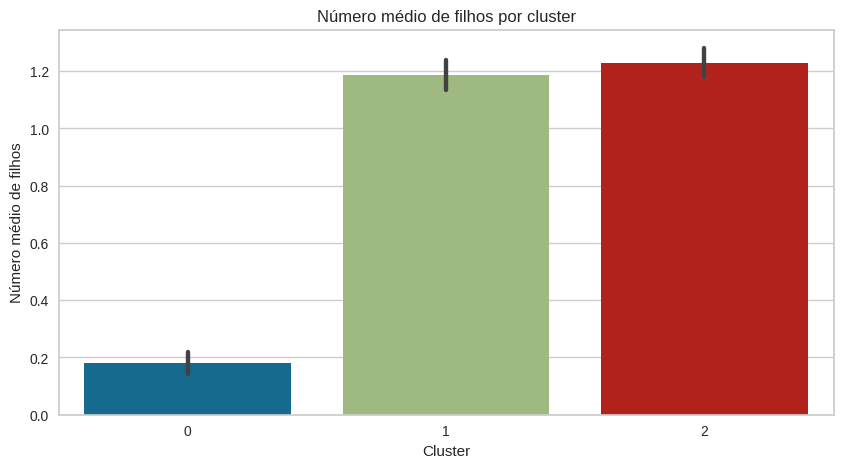

In [429]:

df_train_final['N_Filhos'] = pd.to_numeric(df_train_final['N_Filhos'])

plt.figure(figsize=(10, 5))
sns.barplot(data=df_train_final, x='Cluster', y='N_Filhos', estimator=np.mean)
plt.title('Número médio de filhos por cluster')
plt.xlabel('Cluster')
plt.ylabel('Número médio de filhos')
plt.show()

O **Grupo 0** em sua **media não possui filhos** enquanto o Grupo 1 e 2 possuem em media 1 filho(a)

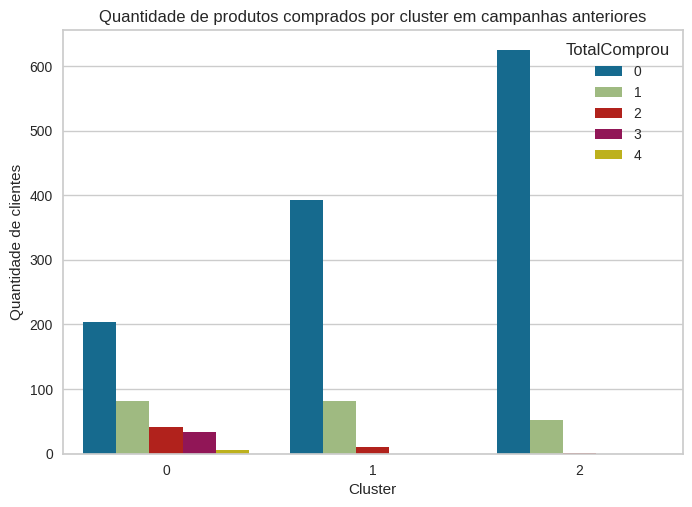

In [430]:
sns.countplot(x='Cluster', hue='TotalComprou', data=df_train_final)
plt.title('Quantidade de produtos comprados por cluster em campanhas anteriores')
plt.xlabel('Cluster')
plt.ylabel('Quantidade de clientes')
plt.show()


é possivel perceber que o **Grupo 0** comprou em campanhas anteriores tendo clientes que compraram em até 4 campanhas, já o **Grupo 1 e 2** em sua maioria, adquiriu o produto uma unica vez. 

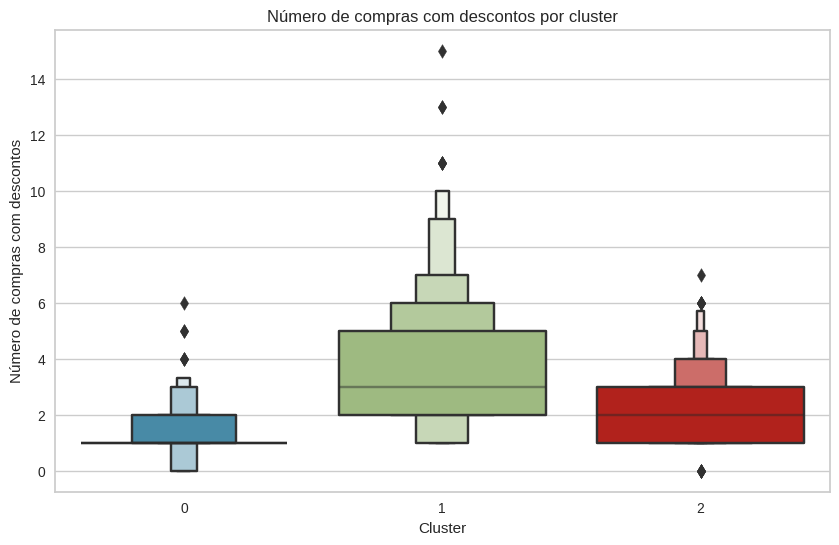

In [431]:
# Plotando o numero de compras feitas com desconto por clusters 
plt.figure(figsize=(10, 6))
sns.boxenplot(x='Cluster', y='NumDealsPurchases', data=df_train_final)
plt.title('Número de compras com descontos por cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de compras com descontos')
plt.show()


É possivel perceber que o Grupo 0 que é o grupo comprador não faz muito uso dos descontos, enquanto o Grupo 1 realiza muitas compras com desconto, seguido do Grupo 2.
- Isso pode ser devido o algoritimo de conceder descontos somente a clientes que estão a algum tempo sem comprar, o que parece mais o caso do Grupo 2 que é um grupo que realiza compras porem aparentemente o fator de ter um desconto acaba influenciando no ato de comprar. 

###Perfil do Cliente Comprador(Respondente)

In [432]:
from tabulate import tabulate

filter_comprador = df_train_final[df_train_final.Cluster == 0]

# Características do Cluster comprador
idade_media = filter_comprador.Age.mean().round(1)
renda = "Possui Alta Renda"
estado_civil = "Casado"
usa_desconto = "Não usa Desconto"
perfil_compra = "Alta Frequencia, Ticket por compra alto"
nivel_escolaridade = "Superior"
possui_filhos = "Sem filhos"

# Dados da tabela
data = [
    ["Idade média", idade_media, "Altos clientes Respondentes entre 65-75"],
    ["Renda", renda, "A Média de renda é acima de 70k"],
    ["Estado civil", estado_civil, "A proporção de Casado e solteiro é muito próxima"],
    ["Usa Desconto?", usa_desconto, "Provavelmente opção de desconto é somente para clientes que compram pouco"],
    ["Perfil de compra", perfil_compra, "N/A"],
    ["Nível de Escolaridade", nivel_escolaridade, "N/A"],
    ["Possui Filhos?", possui_filhos, "N/A"]
]

# Criação da tabela
table = tabulate(data, headers=["Características", "Valor", "Observação"], tablefmt="fancy_grid")

# Formatação do título
title = "Características do Cliente Comprador"
separator = "=" * len(title)
title_formatted = f"\n{separator}\n{title}\n{separator}"

# Adicionar título formatado à tabela
table_with_title = f"{title_formatted}\n{table}"

# Impressão da tabela
print(table_with_title)



Características do Cliente Comprador
╒═══════════════════════╤═════════════════════════════════════════╤═══════════════════════════════════════════════════════════════════════════╕
│ Características       │ Valor                                   │ Observação                                                                │
╞═══════════════════════╪═════════════════════════════════════════╪═══════════════════════════════════════════════════════════════════════════╡
│ Idade média           │ 53.6                                    │ Altos clientes Respondentes entre 65-75                                   │
├───────────────────────┼─────────────────────────────────────────┼───────────────────────────────────────────────────────────────────────────┤
│ Renda                 │ Possui Alta Renda                       │ A Média de renda é acima de 70k                                           │
├───────────────────────┼─────────────────────────────────────────┼───────────────────────────────

In [433]:
#Removendo features que usei apenas na clusterização 
df_train_final.drop(['Cluster','Marital'], axis = 1, inplace = True)

Eu optei por não usar a informação dos grupos na modelagem, pois ao testalos não obtve nenhuma diferença significativa. 

##Correlação

In [434]:
#armazena a coluna response em uma variável
response_col = df_train_final.pop('Response')

#adiciona a coluna response de volta ao dataframe no final
df_train_final.insert(len(df_train_final.columns), 'Response', response_col)

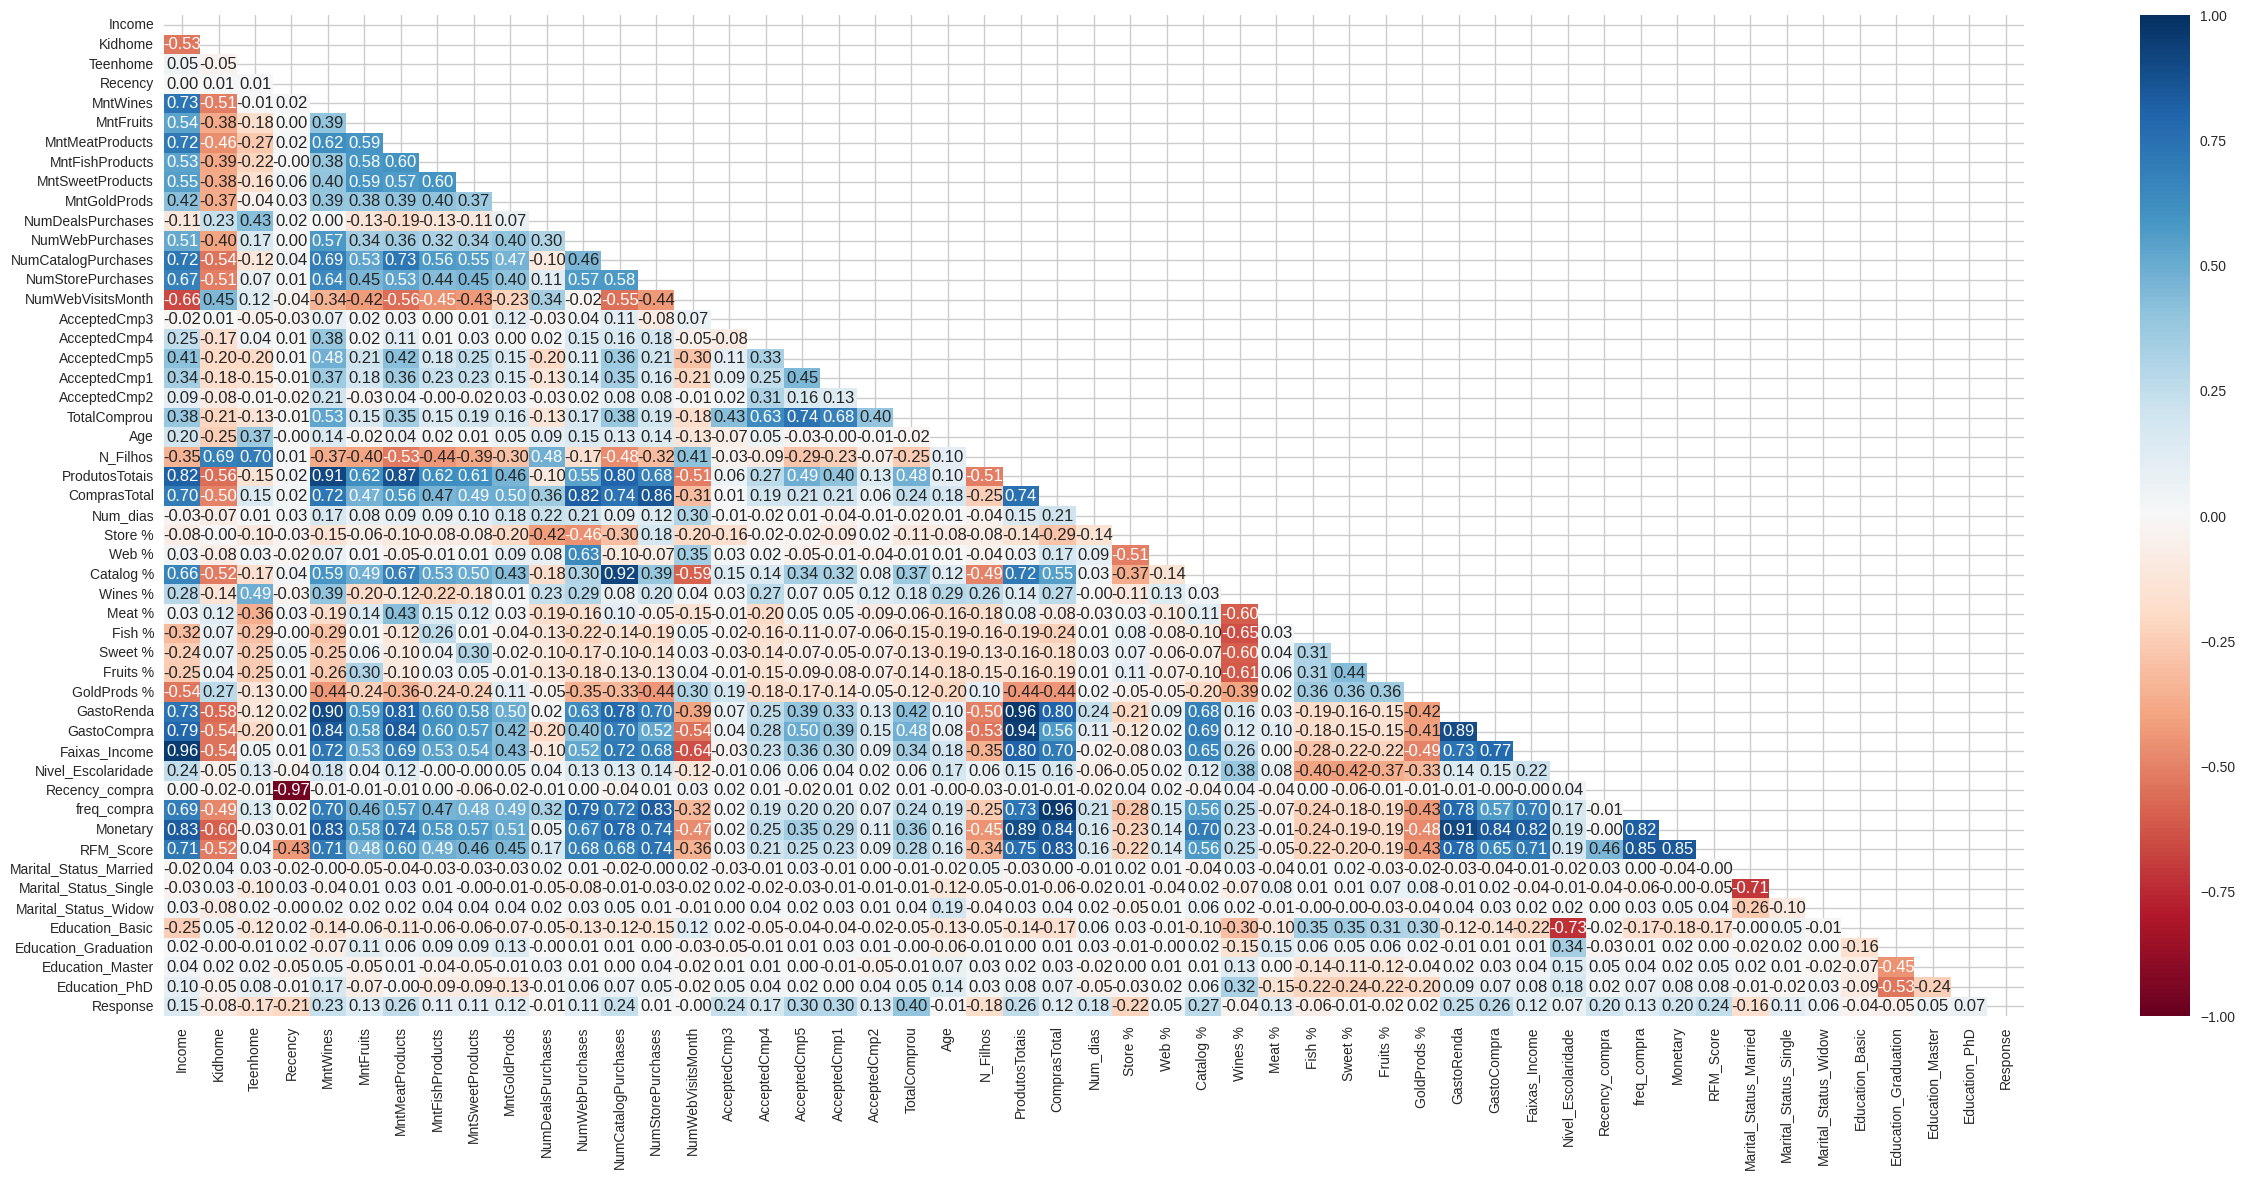

In [435]:
#Plotando a matriz de correlações usando um Heatmap para dar cor aos números
plt.figure(figsize=(30,13))
sns.heatmap(
    df_train_final.drop('Complain', axis = 1).corr(), #Fonte dos dados, nossa matriz de correlação
    annot=True,
    fmt='.2f',
    vmin = -1,
    vmax = 1,
    cmap='RdBu', # Mapa de cores do vermelho (menor) para o azul (maior)
    mask=np.triu( # Faz uma matriz triangular
        np.ones_like(df_train_final.drop('Complain', axis = 1).corr()) # usando como base uma matriz de '1's, do mesmo tamanho que a matriz de correlação
    ) # A máscara vai então 'apagar' a diagonal superior da matriz
           )
plt.show()

Eu usei bastante a correlação de perason para determinar o uso de algumas features, e identificar features que diziam informações repetidas. 
- Note que as features com correlações mais espressivas são originadas do Feature Enginering. 

##Pre-Processamento para o modelo de validação. 

In [436]:
#Criando uma lista com as features que serão transformadas 
power_coluns = ["Income", "Recency", "MntWines", "MntFruits", "MntMeatProducts", "MntSweetProducts", "MntGoldProds", "NumDealsPurchases", 
 "NumCatalogPurchases", "NumStorePurchases", "NumWebVisitsMonth","Age", "ProdutosTotais", "ComprasTotal", 'Num_dias',
 "GastoRenda", "Wines %", "Meat %", "Fish %", "Sweet %", "Fruits %"]

In [437]:
#chamando a funçao de transformação de features
df_train_power = df_train_final[power_coluns] #criando o DF com as features que vão ser transformadas
df_train_power_back = df_train_power.copy() #reserva para usar no conjunto de teste
df_train_power["Response"] = df_train_final["Response"] #adicionando a Target 

#chamando a função 
df_train_power, Melhor_Transf = transformacao_potencia(df_train_power, "Response")
#exibindo as escolhas de transformação 
print("Melhores resultados de transformação para cada feature \t")
for chave in Melhor_Transf:
    print(chave, Melhor_Transf[chave][1],'\t')


Melhores resultados de transformação para cada feature 	
Income cubo 	
Recency **1/4 	
MntWines **2 	
MntFruits x 	
MntMeatProducts x 	
MntSweetProducts x 	
MntGoldProds **1/4 	
NumDealsPurchases raiz_quadrada 	
NumCatalogPurchases x 	
NumStorePurchases raiz_quadrada 	
NumWebVisitsMonth seno 	
Age x 	
ProdutosTotais raiz_quadrada 	
ComprasTotal **1/4 	
Num_dias **4 	
GastoRenda cubo 	
Wines % cubo 	
Meat % exponencial 	
Fish % raiz_quadrada 	
Sweet % raiz_quadrada 	
Fruits % raiz_quadrada 	


A função transformacao_potencia realiza a transformação de variáveis utilizando diferentes funções matemáticas
e escolhe a melhor transformação para cada variável utilizando o teste de chi-quadrado para avaliar a relação
entre a coluna transformada e o target. O resultado da função é um novo dataframe com as variáveis transformadas
e um dicionário com as melhores transformações para cada variável.

In [438]:
#subistituindo as features antigas pelas transformadas 
colunas = df_train_power[power_coluns]
df_train_final.drop(columns=colunas, inplace=True)
df_train_final.drop('Response', axis = 1, inplace=True)
df_train_final = pd.DataFrame(pd.concat([df_train_final, df_train_power], axis=1))

Aqui eu faço a substituição das colunas originais pelas colunas que tiveram o valor transformado. 

In [439]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

# Lista de features que não serão escalonadas
unscaled_features = ['AcceptedCmp2','Kidhome', 'Teenhome', 'AcceptedCmp3', 'AcceptedCmp1', 'AcceptedCmp4', 'AcceptedCmp5', 'Age',
                     'N_Filhos','TotalComprou','Faixas_Income','Nivel_Escolaridade','Recency_compra','freq_compra','Monetary','RFM_Score','Marital_Status_Married','Marital_Status_Single',
                     'Marital_Status_Widow','Education_Basic','Education_Graduation','Education_Master','Education_PhD']

# Lista de features que serão escalonadas
scaled_features = [col for col in df_train_final.columns if col not in unscaled_features]

# Separar a coluna de resposta
response_col = df_train_final['Response']

# Aplicar escalonamento nas features selecionadas
scaler = MinMaxScaler()
transformer = ColumnTransformer(
    transformers=[
        ('scaling', scaler, scaled_features)
    ],
    remainder='passthrough'  # Manter as features não escalonadas na mesma ordem
)

# Aplicar a transformação nas features selecionadas
df_train_final_scaled = transformer.fit_transform(df_train_final)

# Obter os nomes das colunas após a transformação
transformed_columns = scaled_features + unscaled_features

# Criar o novo dataframe com as features escalonadas e a coluna de resposta
df_train_final_scaled = pd.DataFrame(df_train_final_scaled, columns=transformed_columns)

# Copiar as colunas não escalonadas do dataframe original para o dataframe escalonado
df_train_final_scaled[unscaled_features] = df_train_final[unscaled_features]

# Converter as colunas para o tipo float
float_columns = scaled_features + unscaled_features
df_train_final_scaled[float_columns] = df_train_final_scaled[float_columns].astype(float)

#devolvendo a coluna Response para o conjunto de dados e depois copiando o conjunto escalonado para df_train_final
df_train_final_scaled['Response'] = response_col
df_train_final = df_train_final_scaled.copy()

Estou fazendo o escalonamento de features, porem passo uma lista com o nome das features que não quero que sejam escalonadas, estas features em sua maioria são categoricas. 

In [440]:
'''from sklearn.preprocessing import MinMaxScaler
#copiando meu conjunto de dados sem Response
reserva = df_train_final.drop(['Response'],axis=1)

#Colocando os dados em uma mesma escala 
df_train_Power = df_train_final #armazena os valores transformados 
for col in reserva.columns:
    df_train_Power[col] = MinMaxScaler().fit_transform(df_train_final[[col]]).flatten()#transforma o o array 2d em 1d'''

"from sklearn.preprocessing import MinMaxScaler\n#copiando meu conjunto de dados sem Response\nreserva = df_train_final.drop(['Response'],axis=1)\n\n#Colocando os dados em uma mesma escala \ndf_train_Power = df_train_final #armazena os valores transformados \nfor col in reserva.columns:\n    df_train_Power[col] = MinMaxScaler().fit_transform(df_train_final[[col]]).flatten()#transforma o o array 2d em 1d"

In [441]:
#selecionando as features com maior correlação em valor absoluto com a variável target
df_train_corr = abs(df_train_final.corr()['Response']).sort_values(ascending=False)
selecionadas = df_train_corr.index[1:60]

In [442]:

#separando em X e y
X = df_train_final[selecionadas]
y = df_train_final['Response']

In [443]:
#divindo em treino e validação finals 
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(X, y,  test_size =0.3,random_state = 1603,stratify=y)

In [444]:
'''#fazendo oversample da classe 1 para 1/3 da classe 0 
from imblearn.over_sampling import SMOTE

numeric_cols = X_train_final.select_dtypes(include='number').columns
X_train_final[numeric_cols] = X_train_final[numeric_cols].astype('float')
n_samples = {
    0: 910,
    1: 300
}

smote = SMOTE(sampling_strategy=n_samples,random_state=1603)
X_train_final, y_train_final = smote.fit_resample(X_train_final, y_train_final)'''

"#fazendo oversample da classe 1 para 1/3 da classe 0 \nfrom imblearn.over_sampling import SMOTE\n\nnumeric_cols = X_train_final.select_dtypes(include='number').columns\nX_train_final[numeric_cols] = X_train_final[numeric_cols].astype('float')\nn_samples = {\n    0: 910,\n    1: 300\n}\n\nsmote = SMOTE(sampling_strategy=n_samples,random_state=1603)\nX_train_final, y_train_final = smote.fit_resample(X_train_final, y_train_final)"

##Modelo de validação 

              precision    recall  f1-score   support

           0       0.97      0.79      0.87       390
           1       0.41      0.85      0.56        68

    accuracy                           0.80       458
   macro avg       0.69      0.82      0.71       458
weighted avg       0.89      0.80      0.82       458



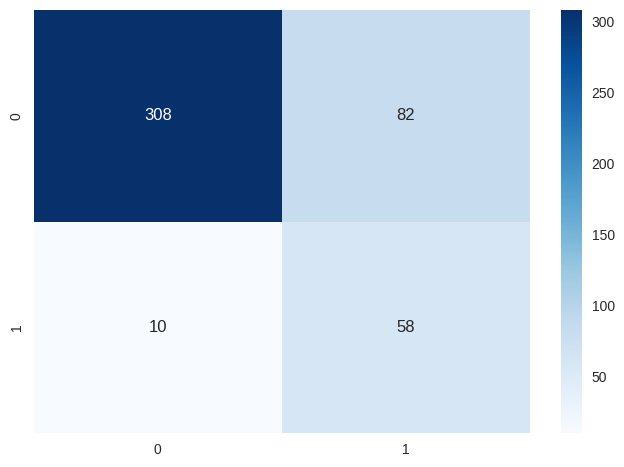

In [445]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score
#criar objeto LogisticRegression com classe LogisticRegressionCV para busca de hiperparâmetros
LR_model = LogisticRegression(class_weight='balanced',penalty = 'l1',solver='liblinear')

#treinar modelo
LR_model.fit(X_train_final, y_train_final)

#aplicar modelo com threshold

predicted = LR_model.predict(X_val_final)
predicted_proba = LR_model.predict_proba(X_val_final)


#Report das metricas
print(classification_report(y_val_final, predicted))

#criando a matriz de confusão
ax = sns.heatmap(confusion_matrix(y_val_final, predicted),
                 annot=True,
                 fmt = 'd',
                 cmap = 'Blues')

#print('Validation Accuracy:', accuracy_score(y_val_final, predicted))

Mesmo com a precisão baixa, o valor alto de recall acaba compensando o gasto com Falsos Positivos. pois o retorno dos clientes que irão de fato comprar o produto compensa este gasto e da uma boa margem de lucro.

Porem vamos tentar melhorar isto com threshold e outros modelos. 

####Analise de Features com Shap

In [446]:
#instalando a biblioteca shap
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Permutation explainer: 459it [00:41,  7.05it/s]


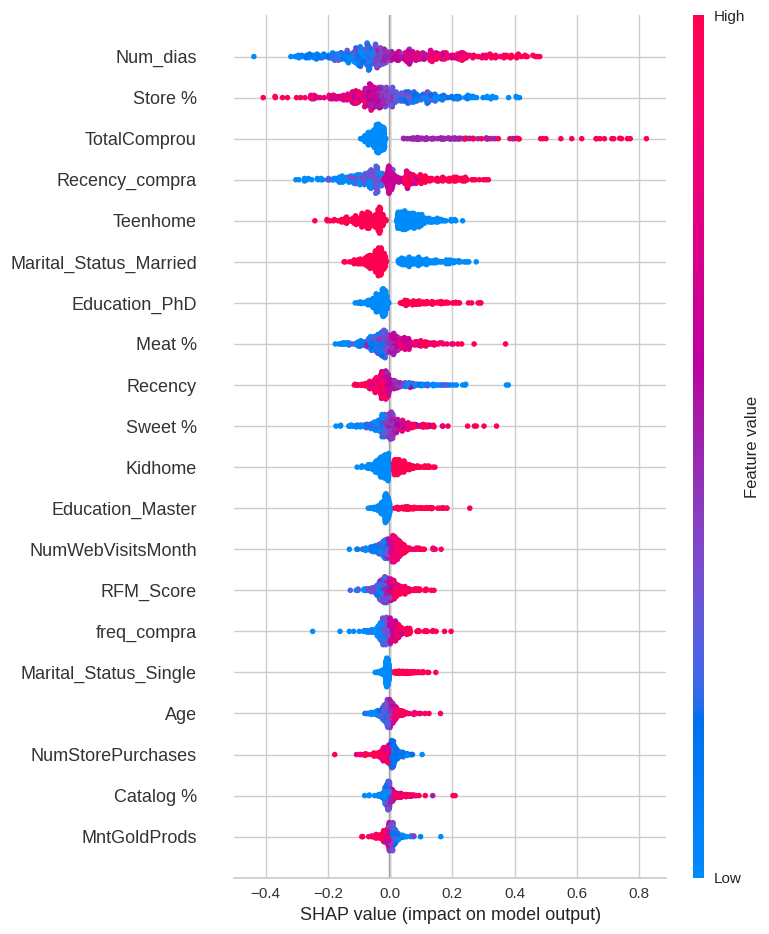

In [447]:
import shap

# Carregando os dados
X = X_val_final

# Carregando o modelo
model = LR_model.predict

# Inicializando o objeto de explainer SHAP com os dados e modelo treinado
explainer = shap.Explainer(model, X)

# Calculando os valores SHAP para todas as amostras de dados
shap_values = explainer(X)

#plot
plt.figure(figsize=(15,60))
shap.summary_plot(shap_values, X)

O **shap** foi fundamental para entender como cada feature estava impactando no modelo. Com base nas informações foi possivel criar **novas features** e testar **transformações de dados**.  

####Visualizando o melhor Threshold 

Fold 1, Threshold 0.10: 0.5065
Fold 2, Threshold 0.10: 0.3467
Fold 3, Threshold 0.10: 0.3791
Fold 4, Threshold 0.10: 0.3977
Fold 5, Threshold 0.10: 0.3418
Fold 1, Threshold 0.15: 0.5379
Fold 2, Threshold 0.15: 0.4062
Fold 3, Threshold 0.15: 0.4143
Fold 4, Threshold 0.15: 0.4151
Fold 5, Threshold 0.15: 0.3768
Fold 1, Threshold 0.20: 0.5714
Fold 2, Threshold 0.20: 0.4262
Fold 3, Threshold 0.20: 0.4409
Fold 4, Threshold 0.20: 0.4490
Fold 5, Threshold 0.20: 0.4160
Fold 1, Threshold 0.25: 0.5812
Fold 2, Threshold 0.25: 0.4602
Fold 3, Threshold 0.25: 0.4828
Fold 4, Threshold 0.25: 0.4604
Fold 5, Threshold 0.25: 0.4561
Fold 1, Threshold 0.30: 0.5818
Fold 2, Threshold 0.30: 0.4505
Fold 3, Threshold 0.30: 0.5000
Fold 4, Threshold 0.30: 0.4706
Fold 5, Threshold 0.30: 0.4808
Fold 1, Threshold 0.35: 0.5981
Fold 2, Threshold 0.35: 0.4854
Fold 3, Threshold 0.35: 0.5437
Fold 4, Threshold 0.35: 0.4687
Fold 5, Threshold 0.35: 0.5263
Fold 1, Threshold 0.40: 0.6139
Fold 2, Threshold 0.40: 0.5051
Fold 3, 

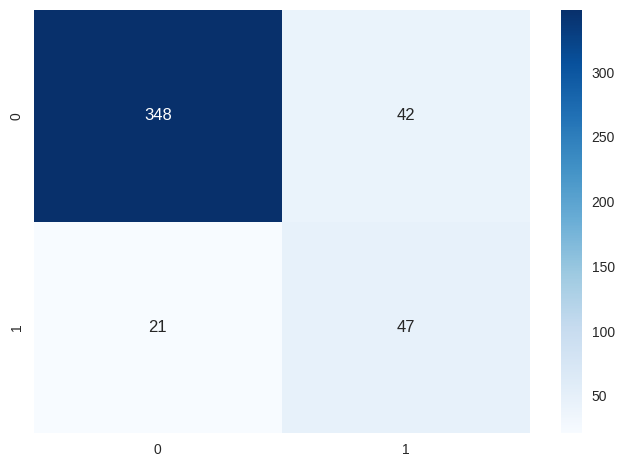

In [448]:
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import f1_score

# definindo o modelo
LR_model = LogisticRegression(class_weight='balanced',penalty = 'l1',solver='liblinear')

# definindo o número de folds
kf = KFold(n_splits=5, shuffle=True, random_state=1603)

# definindo os valores de threshold a serem testados
thresholds = np.arange(0.1, 1.1, 0.05)

# inicializando as variáveis para armazenar os resultados
best_threshold = None
best_score = 0

# inicializando as variáveis para armazenar os resultados
best_threshold = None
best_score = 0

# lista para armazenar os resultados F1 Score para cada valor de threshold para cada fold
threshold_scores = {t: [] for t in thresholds}

# iterando sobre os valores de threshold
for threshold in thresholds:
    # definindo uma função lambda para aplicar o threshold
    threshold_fn = lambda x: 1 if x >= threshold else 0
    
    # aplicando a função de threshold nas probabilidades previstas pelo modelo para cada fold
    for fold, (train_index, test_index) in enumerate(kf.split(X_train_final)):
        train_index = train_index.astype(int)
        test_index = test_index.astype(int)
        LR_model.fit(X_train_final.iloc[train_index], y_train_final.iloc[train_index])
        y_prob = LR_model.predict_proba(X_train_final.iloc[test_index])[:, 1]
        y_pred = list(map(threshold_fn, y_prob))
        score = f1_score(y_train_final.iloc[test_index], y_pred)
        threshold_scores[threshold].append(score)
        print(f'Fold {fold+1}, Threshold {threshold:.2f}: {score:.4f}')
      
# calculando a média do F1 Score para cada valor de threshold
mean_scores = {t: np.mean(scores) for t, scores in threshold_scores.items()}

# selecionando o melhor threshold
best_threshold = max(mean_scores, key=mean_scores.get)
best_score = mean_scores[best_threshold]

# treinando o modelo com o melhor threshold encontrado
threshold_fn = lambda x: 1 if x >= best_threshold else 0
LR_model.fit(X_train_final, y_train_final)

# aplicando o modelo com o melhor threshold aos dados de teste
y_pred = list(map(threshold_fn, LR_model.predict_proba(X_val_final)[:, 1]))

# report das métricas
print(classification_report(y_val_final, y_pred))

# criando a matriz de confusão
ax = sns.heatmap(confusion_matrix(y_val_final, y_pred),
                 annot=True,
                 fmt = 'd',
                 cmap = 'Blues')


print(f"Best threshold: {best_threshold:.2f}, F1 Score: {best_score:.4f}")

O melhor threshold encontrado pelo CV foi de 65% isto melhorou um pouco nossa precisão mas sacrificou bastante o nosso recall, vamos avaliar a curva de FAR e FRR e precision x Recall somente por curiosidade, já que o valor do CV é mais confiavel.  

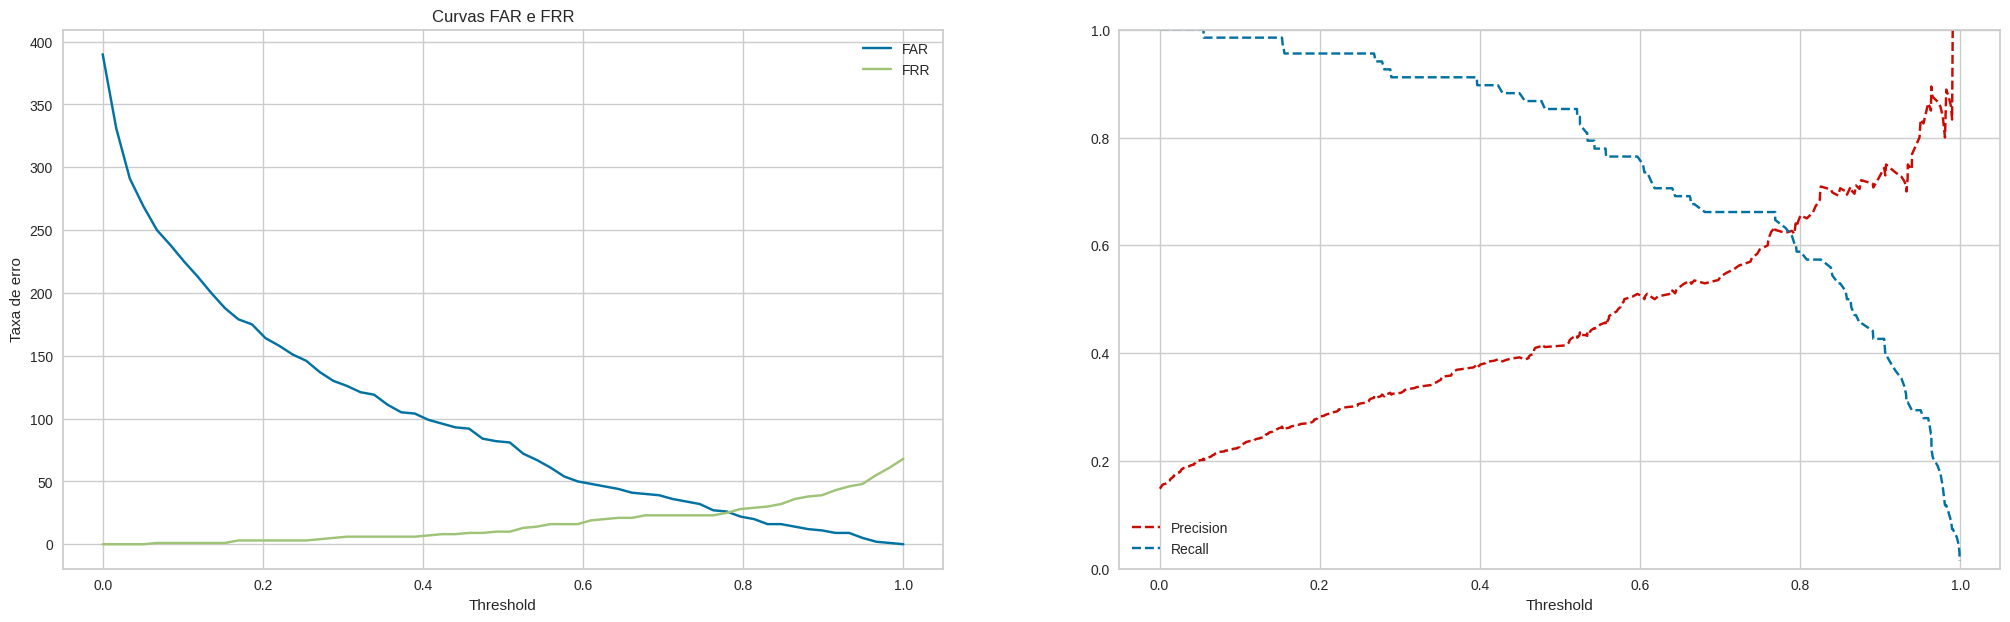

In [449]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(25,7))
plt.subplot(1,2,1)
# Calculando curvas FAR e FRR
far_frr = calculate_far_frr(predicted_proba[:, 1], y_val_final)
# Plotando curvas FAR e FRR
plt.plot(far_frr['plot'].index, far_frr['plot']['far'], label='FAR')
plt.plot(far_frr['plot'].index, far_frr['plot']['frr'], label='FRR')
plt.xlabel('Threshold')
plt.ylabel('Taxa de erro')
plt.title('Curvas FAR e FRR')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
#Calculando curvas Recall e Precision
precisions, recalls, thresholds = precision_recall_curve(y_val_final, predicted_proba[:, 1])
#plotando curvas recall e precision
plt.plot(thresholds, precisions[:-1], "r--", label="Precision")
plt.plot(thresholds, recalls[:-1], "b--", label="Recall")
plt.xlabel("Threshold")
plt.legend()
plt.ylim([0, 1])
plt.xlim([-0.05, 1.05])
plt.grid(True)

plt.show()

Elas se cruzam em 78 porem este de fato não é o melhor ponto de corte o valor default de 50% ainda continua sendo um ponto interessante, a melhor situação seria melhorar a explicabilidade dos dados ou testar outros modelos de forma que a precisão seja um pouco melhor sem afetar o recall. 
- De toda forma se o desempenho do conjunto de teste for semelhante ao conjunto de treinamento já é o suficente para se botar em produção e obter lucros para a proxima campanha de marketing.   

## Preparando o conjunto de teste.

####Pre-Feature Engineering


In [450]:
# Transforma a coluna Dt_Customer em um objeto datetime
X_test['Dt_Customer'] = pd.to_datetime(X_test['Dt_Customer'])

In [451]:
#deletando outliers de data de nascimento 
X_test.drop(X_test[X_test.Year_Birth <= 1900].index,inplace = True)

# Criando uma feature que diz a idade do cliente
X_test["Age"] = 2023 - X_test["Year_Birth"]

# Criando uma nova coluna chamada 'TotalComprou' baseada nas campanhas anteriores 
X_test['TotalComprou'] = X_test[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].sum(axis=1)


In [452]:
X_test.shape, y_test.shape

((669, 30), (672,))

####Dados nulos

In [453]:
#verificando os dados nulos 
X_test.isnull().mean()[X_test.isnull().mean() > 0].sort_values(ascending=False)


Income    0.013453
dtype: float64

In [454]:
#dropando linhas com nulos em income
X_test.dropna(subset=['Income'], inplace=True)

####Dropando colunas que não pretendo usar 


In [455]:
#dropando colunas que não irei usar 
X_test = X_test.drop(['Year_Birth','Z_Revenue','Z_CostContact','ID'],axis = 1)

#### Ajustando dados das variaveis categoricas 

In [456]:
#tratando os dados da variavel Marital_Status
X_test.Marital_Status = X_test.Marital_Status.replace('Together', 'Married')
X_test.Marital_Status = X_test.Marital_Status.replace('Alone', 'Single')
X_test.drop(X_test[X_test.Marital_Status =='Absurd'].index, inplace = True)
X_test.drop(X_test[X_test.Marital_Status =='YOLO'].index, inplace = True)

####Tratando dos outliers 

In [457]:
X_test['y'] = y_test

In [458]:
#Trunkando a Variavel Income em percentil 99%
p99 = X_test['Income'].quantile(0.99)
X_test['Income'] = np.where(X_test['Income'] > p99, p99, X_test['Income'])

In [459]:
#pegando o nome das features numericas
numeric_cols = X_test.select_dtypes(include=[np.number]).columns

In [460]:
df_train_outliers.drop(['Response'],axis = 1, inplace = True)
# Removendo outliers do conjunto de teste usando os limites do conjunto de treino
X_test_no_outliers = remove_outliers_test(df_train_outliers,X_test,3)

#Convertendo o array de volta para dataFrame e setando o index 
X_test_no_outliers = pd.DataFrame(X_test_no_outliers, columns=X_test.columns)
X_test_no_outliers[numeric_cols] = X_test_no_outliers[numeric_cols].astype(int)
X_test = X_test_no_outliers.copy()

#Removendo y de X_test 
y_test = X_test['y']
X_test.drop('y',axis = 1, inplace = True)

A Função remove_outliers_test usa os dados de treinamento para calcular a distancia de mahalonabis como sua media e desvio padrão e so aplica a decisão de corte no conjunto de test 

####Feature Engineering

In [461]:
#criando uma coluna que conta o numero total de filhos.
X_test['N_Filhos'] = X_test.Teenhome + X_test.Kidhome

#criando uma feature chamada ProdutosTotais, que representa o numero total de produtos comprados 
X_test['ProdutosTotais'] = X_test[['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts',]].sum(axis=1)

#Criando a feature ComprasTotal que representa o numero total de compras efetuadas 
X_test['ComprasTotal'] = X_test[['NumCatalogPurchases','NumStorePurchases','NumWebPurchases','NumDealsPurchases']].sum(axis=1)


In [462]:
#criando uma coluna contendo o numero de dias que o cliente se inscreveu.
X_test['Num_dias'] = X_test['Dt_Customer'].apply(totalDays)
#criando features de porcentagem de compras por plataforma de venda 
X_test['Store %'] = X_test.apply(lambda row: calc_porcent(row['NumStorePurchases'], row['ComprasTotal']),axis=1)
X_test['Web %'] = X_test.apply(lambda row: calc_porcent(row['NumWebPurchases'], row['ComprasTotal']),axis=1)
X_test['Catalog %'] = X_test.apply(lambda row: calc_porcent(row['NumCatalogPurchases'], row['ComprasTotal']),axis=1)
#criando features de porcentagem de compras por cada produto vendido
X_test['Wines %'] = X_test.apply(lambda row: calc_porcent(row['MntWines'], row['ProdutosTotais']),axis=1)
X_test['Meat %'] = X_test.apply(lambda row: calc_porcent(row['MntMeatProducts'], row['ProdutosTotais']),axis=1)
X_test['Fish %'] = X_test.apply(lambda row: calc_porcent(row['MntFishProducts'], row['ProdutosTotais']),axis=1)
X_test['Sweet %'] = X_test.apply(lambda row: calc_porcent(row['MntSweetProducts'], row['ProdutosTotais']),axis=1)
X_test['Fruits %'] = X_test.apply(lambda row: calc_porcent(row['MntFruits'], row['ProdutosTotais']),axis=1)
X_test['GoldProds %'] = X_test.apply(lambda row: calc_porcent(row['MntGoldProds'], row['ProdutosTotais']),axis=1)

#criando coluna GastoRenda proporção de gasto em relação a renda *
X_test['GastoRenda'] = X_test.apply(lambda row: calc_porcent(row['ProdutosTotais'], row['Income']*2),axis=1)

#criando a coluna Aceitou% proporção de compras feitas  por numero de campanhas de marketing anteriores *
#X_test['Comprou %'] = X_test['TotalComprou'] / len(X_test['TotalComprou'].value_counts())

#criando a coluna GastoCompra que armazena o gasto por compra de cada cliente. 
X_test['GastoCompra'] =X_test.apply(lambda row: calc_porcent(row['ProdutosTotais'], row['ComprasTotal']),axis=1)

#####RFM

In [463]:
#Criando grupos de Recency 
X_test['Recency_compra'] = pd.cut(X_test['Recency'],bins=[-1,np.percentile(X_test.Recency, 25),np.percentile(X_test.Recency, 50), np.percentile(X_test.Recency, 75), np.inf], 
                                    labels=[3, 2, 1, 0]).astype("Int64")

#criando os grupos de frequencia com base nos quartils de CompraTotal
X_test['freq_compra'] = pd.cut(X_test['ComprasTotal'], bins=[-1,np.percentile(X_test.ComprasTotal, 25),np.percentile(X_test.ComprasTotal, 50), np.percentile(X_test.ComprasTotal, 75), np.inf], 
                                  labels=[0, 1, 2, 3]).astype("float").astype("Int64") 

#criando  os grupos de Monetary com base nos quatis de ProdutosTotais
X_test['Monetary'] = pd.cut(X_test['ProdutosTotais'], bins=[-1, np.percentile(X_test.ProdutosTotais, 25),np.percentile(X_test.ProdutosTotais, 50), np.percentile(X_test.ProdutosTotais, 75), np.inf], 
                                  labels=[0, 1, 2, 3]).astype("int")        

#criando o RFM_SCORE
X_test['RFM_Score'] = X_test.Recency_compra + X_test.freq_compra + X_test.Monetary                           

####Segmentação demografica

In [464]:
#Segmentação por renda
X_test['Faixas_Income'] = pd.cut(X_test['Income'], bins=[0,np.percentile(X_test.Income, 25),np.percentile(X_test.Income, 50), np.percentile(X_test.Income, 75), np.inf], labels=[0,1,2,3]).astype('Int64')

#Grupos por nivel de escolaridade 
mapeamento = {'Basic': 0,
              '2n Cycle': 1,
              'Graduation': 2,
              'Master': 2,
              'PhD': 2}

X_test['Nivel_Escolaridade'] = X_test['Education'].map(mapeamento)

#### Clustering

In [465]:
X_test.drop('Dt_Customer',axis = 1, inplace = True)

In [466]:
#fazendo one hot nas variaveis categoricas para o modelo 
X_test = pd.get_dummies(X_test, columns=['Marital_Status','Education'], drop_first=True)

In [467]:
X_test = X_test.reindex(columns=cluster_df.columns)

In [468]:
'''df_STD_T = pd.DataFrame(clust_scaler.transform(X_test))  # Usando apenas transform()

# Aplicando o PCA usando as informações do PCA do conjunto de treinamento
df_PCA_T = pca.transform(df_STD_T)   # pca é o objeto PCA ajustado no conjunto de treinamento'''

'df_STD_T = pd.DataFrame(clust_scaler.transform(X_test))  # Usando apenas transform()\n\n# Aplicando o PCA usando as informações do PCA do conjunto de treinamento\ndf_PCA_T = pca.transform(df_STD_T)   # pca é o objeto PCA ajustado no conjunto de treinamento'

In [469]:
'''# K-means clustering for customer segmentation (k = 3)
km = KMeans(n_clusters=4, random_state=1)
km.fit(df_PCA_T)
predict = km.predict(df_PCA_T)

# Adicionando as colunas de grupos como dummies
cluster_dummies = pd.get_dummies(predict, prefix='Cluster', drop_first=True)
X_test = pd.concat([X_test, cluster_dummies], axis=1)'''


"# K-means clustering for customer segmentation (k = 3)\nkm = KMeans(n_clusters=4, random_state=1)\nkm.fit(df_PCA_T)\npredict = km.predict(df_PCA_T)\n\n# Adicionando as colunas de grupos como dummies\ncluster_dummies = pd.get_dummies(predict, prefix='Cluster', drop_first=True)\nX_test = pd.concat([X_test, cluster_dummies], axis=1)"

####Transformação e escala 

In [470]:
#cria um novo conjunto somente com colunas especificas
df_test_power = X_test[power_coluns]
#chama a função passando o conjunto de treino de teste e o targe do conjunto de treino. 
df_test_power, Melhor_Transf = transformacao_potencia_test(df_train_power_back,df_test_power,df_train_power["Response"])

a função transformacao_potencia_test usa as decisões tomadas com base nos dados de treinamento para transformar os dados de teste. 

In [471]:
#subistituindo as features antigas pelas transformadas 
colunas = df_test_power[power_coluns]
X_test.drop(columns=colunas, inplace=True)
X_test = pd.DataFrame(pd.concat([X_test, df_test_power], axis=1))

In [472]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

# Lista de features que não serão escalonadas
unscaled_features = ['AcceptedCmp2','Kidhome', 'Teenhome', 'AcceptedCmp3', 'AcceptedCmp1', 'AcceptedCmp4', 'AcceptedCmp5', 'Age',
                     'N_Filhos','TotalComprou','Faixas_Income','Nivel_Escolaridade','Recency_compra','freq_compra','Monetary','RFM_Score','Marital_Status_Married','Marital_Status_Single',
                     'Marital_Status_Widow','Education_Basic','Education_Graduation','Education_Master','Education_PhD']

# Lista de features que serão escalonadas
scaled_features = [col for col in X_test.columns if col not in unscaled_features]



# Aplicar escalonamento nas features selecionadas
scaler = MinMaxScaler()
transformer = ColumnTransformer(
    transformers=[
        ('scaling', scaler, scaled_features)
    ],
    remainder='passthrough'  # Manter as features não escalonadas na mesma ordem
)

# Aplicar a transformação nas features selecionadas
X_test_scaled = transformer.fit_transform(X_test)

# Obter os nomes das colunas após a transformação
transformed_columns = scaled_features + unscaled_features

# Criar o novo dataframe com as features escalonadas e a coluna de resposta
X_test_scaled = pd.DataFrame(X_test_scaled, columns=transformed_columns)

# Copiar as colunas não escalonadas do dataframe original para o dataframe escalonado
X_test_scaled[unscaled_features] = X_test[unscaled_features]

# Converter as colunas para o tipo float
float_columns = scaled_features + unscaled_features
X_test_scaled[float_columns] = X_test_scaled[float_columns].astype(float)


X_test = X_test_scaled.copy()

In [473]:
'''from sklearn.preprocessing import MinMaxScaler
#copiando meu conjunto de dados 
reserva = X_test

#Colocando os dados em uma mesma escala 
df_train_Power = X_test #armazena os valores transformados 
for col in reserva.columns:
    df_train_Power[col] = MinMaxScaler().fit_transform(X_test[[col]]).flatten()#transforma o o array 2d em 1d
'''

'from sklearn.preprocessing import MinMaxScaler\n#copiando meu conjunto de dados \nreserva = X_test\n\n#Colocando os dados em uma mesma escala \ndf_train_Power = X_test #armazena os valores transformados \nfor col in reserva.columns:\n    df_train_Power[col] = MinMaxScaler().fit_transform(X_test[[col]]).flatten()#transforma o o array 2d em 1d\n'

In [474]:
#separando o conjunto de treino em X e y
X = df_train_final.drop('Response',axis = 1)
y = df_train_final['Response']
X.drop('Complain',axis = 1, inplace = True)

In [475]:
'''#fazendo oversample dos dados de treinamento
from imblearn.over_sampling import SMOTE

numeric_cols = X.select_dtypes(include='number').columns
X[numeric_cols] = X[numeric_cols].astype('float')

n_samples = {
    0: 1300,
    1: 435
}
smote = SMOTE(sampling_strategy=n_samples,random_state=1603)
X, y = smote.fit_resample(X, y)'''

"#fazendo oversample dos dados de treinamento\nfrom imblearn.over_sampling import SMOTE\n\nnumeric_cols = X.select_dtypes(include='number').columns\nX[numeric_cols] = X[numeric_cols].astype('float')\n\nn_samples = {\n    0: 1300,\n    1: 435\n}\nsmote = SMOTE(sampling_strategy=n_samples,random_state=1603)\nX, y = smote.fit_resample(X, y)"

In [476]:
#ordenando o conjunto de teste pelo conjunto de treino
X_test.drop('Complain',axis = 1, inplace = True)
X_test = X_test.reindex(columns=X.columns)
X_test.shape, y_test.shape

((644, 50), (644,))

##Modelo de teste

              precision    recall  f1-score   support

           0       0.99      0.78      0.87       552
           1       0.42      0.93      0.58        92

    accuracy                           0.81       644
   macro avg       0.70      0.86      0.73       644
weighted avg       0.91      0.81      0.83       644



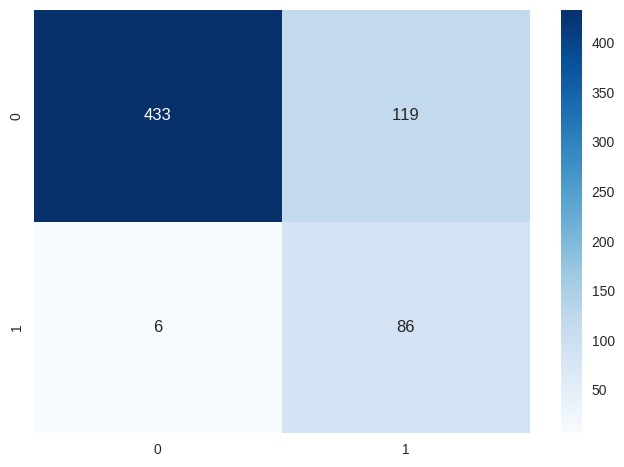

In [477]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score

#criar objeto LogisticRegression com classe LogisticRegressionCV para busca de hiperparâmetros
LR_model = LogisticRegression(class_weight='balanced', penalty = 'l1',solver='liblinear')

#treinar modelo
LR_model.fit(X, y)

#aplicar modelo com threshold

predicted = LR_model.predict(X_test)
predicted_proba = LR_model.predict_proba(X_test)


#Report das metricas
print(classification_report(y_test, predicted))

#criando a matriz de confusão
ax = sns.heatmap(confusion_matrix(y_test, predicted),
                 annot=True,
                 fmt = 'd',
                 cmap = 'Blues')
#print('Validation Accuracy:', accuracy_score(y_test, predicted))

Para minha surpresa o desempenho no conjunto de teste com recall foi maior do que no conjunto de treinamento, apesar de termos uma precisão de apenas 42% já conseguimos solucionar o problema proposto, vou calcular o desempenho de cada modelo com numeros $$

In [478]:
# @title Comparando retorno das campanhas com e sem o modelo 
import pandas as pd

data = {
    'Nº de clientes Contatados': ['100.000', '100.000'],
    'Custo': ['300.000.00', '300.000.00'],
    'Retorno': ['462.000.00', '165.000.00'],
    'Penalidade': ['-21.840.00','N/A'],
    'Lucro': ['140.160.00', '-135.000.00']
}

df = pd.DataFrame(data)
df = df.rename(index={0: 'Com Modelo', 1: 'Sem Modelo'})
styled_df = df.style.set_table_styles([
    {'selector': 'th', 'props': [('font-size', '18px')]}
])

styled_df


,Nº de clientes Contatados,Custo,Retorno,Penalidade,Lucro
Com Modelo,100.000,300.000.00,462.000.00,-21.840.00,140.160.00
Sem Modelo,100.000,300.000.00,165.000.00,N/A,-135.000.00


Vamos analisar em detalhes o cálculo apresentado acima. Ao contatar 100 mil clientes usando o modelo, obtemos uma precisão de 42%, o que significa que 42 mil pessoas comprariam o produto. Isso resulta em um retorno de 462.000, considerando que cada cliente que compra o produto gera um retorno de 11.

Agora, vamos considerar as deduções necessárias. Primeiramente, é preciso subtrair o custo de contatar os 100 mil clientes. Para cada cliente contatado, o custo é de 3, o que totaliza um custo de 300 mil.

Além disso, devemos deduzir os falsos negativos, que são clientes que comprariam o produto, mas o modelo erroneamente previu que não comprariam. Esses falsos negativos correspondem a 6.5%(valor obtido com o calculo de FN/FN+VP) dos 42 mil clientes, ou seja, 2730 clientes. Nesse caso, optamos por subtrair 8 de cada cliente comprador que não foi contatado (11 de retorno - 3 de custo de contato que não foi feito).

É importante observar que a penalidade é o fator que mais influencia no lucro. Por exemplo, se tivermos um modelo com uma precisão maior, porém um recall menor, teremos uma penalidade alta, pois cada cliente que poderia comprar o produto e não é selecionado pelo modelo resulta em uma perda de 8. No entanto, é válido mencionar que se não considerarmos como prejuízo um cliente que compraria o produto e não foi selecionado pelo modelo conseguiriamos diminuir o custo da campanha com falsos positivos e obtemos um lucro maior em COMPARAÇÃO ao valor gasto com o custo de contatar os clientes.

Mas ressalto novamente é preferível minimizar os falsos negativos, pois cada cliente não contatado que de fato compraria o produto representa uma oportunidade de venda perdida. Embora isso possa resultar em um aumento nos falsos positivos (contatar clientes que não comprariam), o benefício de aproveitar todas as oportunidades de venda supera esse custo.

              precision    recall  f1-score   support

           0       0.97      0.87      0.92       552
           1       0.53      0.85      0.65        92

    accuracy                           0.87       644
   macro avg       0.75      0.86      0.78       644
weighted avg       0.91      0.87      0.88       644



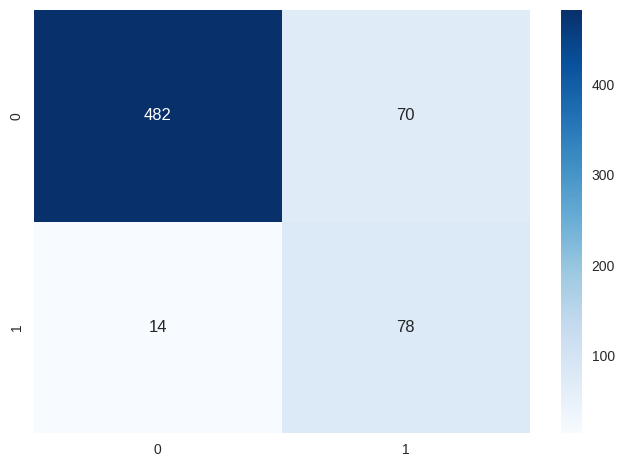

In [479]:
#plotando com o melhor threshold definido com os dados de treino.
threshold = 0.65#Treshold encontrado com validação cruzada nos dados de treino
predicted_proba = LR_model.predict_proba(X_test)[:,1] # probabilidade da classe 1
predicted = (predicted_proba > threshold).astype(int) # predição com threshold aplicado

# Report das metricas
print(classification_report(y_test, predicted))
# criando a matriz de confusão
ax = sns.heatmap(confusion_matrix(y_test, predicted),
                 annot=True,
                 fmt = 'd',
                 cmap = 'Blues')
#print('Validation Accuracy:', metrics.accuracy_score(y_test, predicted))

Ao utilizar o threshold encontrado durante a validação do modelo, foi possível realizar um ajuste equilibrado entre a precisão e o recall. Com essa configuração, obtivemos um ganho de 12 pontos percentuais na precisão e uma perda de apenas 8 pontos percentuais no recall. Embora o recall seja nossa prioridade, essa troca se mostra válida devido à proporção favorável entre ganho e perda.
Essa estratégia nos permite alcançar uma maior precisão na identificação dos clientes propensos a comprar após uma campanha de marketing, sem comprometer de forma significativa a taxa de recall.

In [480]:
# @title Comparando retorno das campanhas com e sem o modelo 
import pandas as pd

data = {
    'Nº de clientes Contatados': ['100.000', '100.000'],
    'Custo': ['300.000.00', '300.000.00'],
    'Retorno': ['583.000.00', '165.000.00'],
    'Penalidade': ['-87.450.00','N/A'],
    'Lucro': ['195.550.00', '-135.000.00']
}

df = pd.DataFrame(data)
df = df.rename(index={0: 'Com Modelo', 1: 'Sem Modelo'})
styled_df = df.style.set_table_styles([
    {'selector': 'th', 'props': [('font-size', '18px')]}
])

styled_df


,Nº de clientes Contatados,Custo,Retorno,Penalidade,Lucro
Com Modelo,100.000,300.000.00,583.000.00,-87.450.00,195.550.00
Sem Modelo,100.000,300.000.00,165.000.00,N/A,-135.000.00


É relevante observar que a penalidade aumentou devido à queda no recall, o que resultou em um aumento nos falsos negativos. No entanto, considerando que obtivemos um ganho significativo em precisão, reduzindo os falsos positivos, o benefício financeiro compensa essa perda.